In [1]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import xarray as xr
import numpy as np
import scipy
import plotly.express as px
from scipy.stats import mstats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import csv
import fiona
import geopandas
import os
import random
import plotly.graph_objects as go
import contextily as cx
from numpy import log10
import folium

In [2]:
### things to add: GDPPC percentage, one location for both scenarios and plot on the same graph (histclim and the forward porjections), 
### wanna turn all functions into module so that it imports TOE and have all functions be in library (to import), this allows to write script to run on command line, point and go (Ask Alex)
### all functions go into TOE.py folder, and then import
### can start by exporting these functions
### graphs will only be produced through TOE net cdf file
### split into notebooks, one that produces net cdf files, and another that imports TOE netcdfs to make graphs and figures


# Notebook Summary

This Jupyter notebook is designed to analyze the time of emergence (ToE) for human mortality due to extreme temperatures in the context of climate change. The mortality data used in this analysis is derived from [Carleton et al. (2022)][1], which provides detailed datasets on mortality rates. These datasets are organized by different combinations of Representative Concentration Pathways (RCPs), Shared Socioeconomic Pathways (SSPs), General Circulation Models (GCMs), and Integrated Assessment Models (IAMs). 

In this notebook, we specifically focus on the mortality data for individuals aged 64 and younger. Our goal is to identify the time of emergence, which is defined as the point in time when the signal of climate change-induced mortality becomes statistically distinct from the background variability. This analysis will help us understand the potential future impacts of climate change on human health, particularly for younger populations, under various climate and socioeconomic scenarios.

[1]:https://academic.oup.com/qje/article/137/4/2037/6571943
---


# [Carleton et al. (2022)][1] Data Summary
## Mortality Data

Mortality data are collected independently from 40 countries, covering mortality outcomes for 38% of the global population. This dataset represents a significant increase in coverage compared to previous studies, which typically focus on individual countries or regions, or combine small nonrandom samples from multiple countries. 

- **Spatial and Temporal Coverage**: The data is harmonized into a single multicountry unbalanced panel dataset of age-specific annual mortality rates, categorized into three age groups: < 5, 5–64, and > 64. The unit of observation is the second administrative unit (ADM2), equivalent to a county in the United States, by year.

### Country-specific Data:

- **Brazil**: 228,762 records (ADM2, 1997–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **Chile**: 14,238 records (ADM2, 1997–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **China**: 7,488 records (ADM2, 1991–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **EU**: 13,013 records (NUTS2, 1990–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **France**: 3,744 records (ADM2, 1998–2010), mortality rates for 0–19, 20–64, and > 64 age groups.
- **India**: 12,505 records (ADM2, 1957–2001), mortality rates for all ages.
- **Japan**: 5,076 records (ADM1, 1975–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **Mexico**: 146,835 records (ADM2, 1990–2010), mortality rates for < 5, 5–64, and > 64 age groups.
- **United States**: 401,542 records (ADM2, 1968–2010), mortality rates for < 5, 5–64, and > 64 age groups.

## Historical Climate Data:

- **GMFD, V1**: Provided by Sheffield, Goteti, and Wood (2006) - Reanalysis and interpolation, 0.25° temperature and precipitation data from Princeton University.
- **BEST**: Provided by Rohde et al. (2013) - Interpolation, 1° temperature data from Berkeley Earth.
- **UDEL**: Provided by Matsuura and Willmott (2007) - Interpolation, 0.5° precipitation data from the University of Delaware.

### Notes:

- **Mortality Rate**: Reported in units of deaths per 100,000 population. Outliers are winsorized at the 1% level at the high end of the distribution across administrative regions for each country.
- **Covariate Values**: Average values over the years in each country sample.
- **ADM Levels**: ADM2 refers to the second administrative level (e.g., county), and ADM1 refers to the first administrative level (e.g., state). NUTS2 refers to the Nomenclature of Territorial Units for Statistics 2nd level, specific to the European Union.
- **GDP Per Capita**: Values are in constant 2005 dollars purchasing power parity.
- **Temperature Data**: Average daily temperature and the number of days above 28°C are population-weighted using 2010 population values.
- **EU Data**: Covers 33 countries, with most records beginning in 1990.
- **France**: Separated from the rest of the EU due to availability of higher-resolution mortality data.
- **India**: Mortality rates may be understated due to incomplete registration of deaths.

---

[1]:https://academic.oup.com/qje/article/137/4/2037/6571943

## Function: `get_file_path`

The `get_file_path` function is designed to construct and return the file path for specific mortality data files based on the given parameters. This function is essential for managing and accessing the various datasets used in the analysis of human mortality due to extreme temperatures and climate change.

## Parameters:

- `dat_dir` (str): The base directory where the data is stored.
- `rcp` (str): The Representative Concentration Pathway (RCP) scenario.
- `iam` (str): The Integrated Assessment Model (IAM) scenario.
- `ssp` (str): The Shared Socioeconomic Pathway (SSP) scenario.
- `mortality_file` (str): The specific mortality file type needed, which can be 'fn_full', 'fn_inc', or 'fn_none'.

## Functionality:

1. **Data Dictionary**: A dictionary (`data_dict`) maps the `mortality_file` parameter to the corresponding file names:
    - `Full Climate and Income Adpation Scenario: 'fn_full'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.nc4`
    - `Full Income Adaptation, no Climate Adpation Scenario: 'fn_inc'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-incadapt.nc4`
    - `No Climate and no Income Adapation Scenario: 'fn_none'`: `Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4`

2. **File Name Retrieval**: The function retrieves the file name from the dictionary based on the `mortality_file` parameter. If an invalid file name is provided, a `ValueError` is raised.

3. **Path Construction**: The function constructs the file path using `os.path.join`, combining the base directory (`dat_dir`) with the specified `rcp`, 'CCSM4', `iam`, `ssp`, and the retrieved file name.

4. **Return**: The constructed file path is returned.

This function ensures a standardized and error-checked approach to accessing the necessary mortality data files for further analysis.

---

In [3]:
def get_file_path(dat_dir, rcp, iam, ssp, mortality_file):
    data_dict = {
        'fn_full': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.nc4',
        'fn_inc': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-incadapt.nc4',
        'fn_none': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4',
    }
    
    file_name = data_dict.get(mortality_file, '')
    if not file_name:
        raise ValueError("Invalid file name provided.")

    path = os.path.join(dat_dir, rcp, 'CCSM4', iam, ssp, file_name)
    return path

### focus on getting function defintions into different file

## Function: `get_histclim_file_path`

Similar to the `get_file_path`, the `get_histclim_file_path` function is designed to construct and return the file path for historical climate mortality data files based on the given parameters. This function is crucial for managing and accessing the historical climate datasets required for analyzing human mortality due to extreme temperatures and climate change.

### Parameters:

- `histclim_dat_dir` (str): The base directory where the historical climate data is stored.
- `rcp` (str): The Representative Concentration Pathway (RCP) scenario.
- `iam` (str): The Integrated Assessment Model (IAM) scenario.
- `ssp` (str): The Shared Socioeconomic Pathway (SSP) scenario.
- `histclim_file` (str): The specific historical climate file type needed, which can be 'fn_histclim'.

In [4]:
def get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file):
    histclim_data_dict = {
        'fn_histclim': 'Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim.nc4'
    }
    
    histclim_file_name = histclim_data_dict.get(histclim_file, '')
    if not histclim_file_name:
        raise ValueError("Invalid file name provided.")

    histclim_path = os.path.join(histclim_dat_dir, rcp, 'CCSM4', iam, ssp, histclim_file_name)
    return histclim_path
    

## Function: `get_econ_file_path`

Similar to `get_file_path` and `get_histclim_file_path`, the `get_econ_file_path` function is designed to construct and return the file path for economic data files based on the given parameters. This function is important for managing and accessing the socioeconomic datasets required for the analysis of human mortality due to extreme temperatures and climate change.

### Parameters:

- `econ_dat_dir` (str): The base directory where the economic data is stored.
- `econ_file` (str): The specific socioeconomic pathway file needed, which can be 'SSP1', 'SSP2', 'SSP3', 'SSP4', or 'SSP5'.

In [5]:
def get_econ_file_path(econ_dat_dir, econ_file):
    data_dict = {
        'SSP1': 'SSP1.nc4',
        'SSP2': 'SSP2.nc4',
        'SSP3': 'SSP3.nc4',
        'SSP4': 'SSP4.nc4',
        'SSP5': 'SSP5.nc4'
    }
    
    econ_file_name = data_dict.get(econ_file, '')
    if not econ_file_name:
        raise ValueError("Invalid file name provided.")

    econ_path = os.path.join(econ_dat_dir, econ_file_name)
    return econ_path

## Data Directories and Scenario Definitions

In this section, we define the data directories and the available scenarios for the analysis of human mortality due to extreme temperatures and climate change. These definitions are for organizing and accessing the necessary datasets for the study.

### Data Directories:

- `dat_dir`: This directory contains the main mortality projection data files.

  /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single
  ```

- `econ_dat_dir`: This directory contains the economic variables data files.
  
  /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/
  ```

- `histclim_dat_dir`: This directory contains the historical climate data files.
            /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single
  ```

### Available Scenarios:

- **Representative Concentration Pathways (RCPs)**: These pathways describe different greenhouse gas concentration trajectories.
  - `'45'`: RCP4.5, a stabilization scenario where radiative forcing stabilizes at 4.5 W/m².
  - `'85'`: RCP8.5, a high greenhouse gas emissions scenario.

- **Integrated Assessment Models (IAMs)**: These models represent different socioeconomic pathways and their associated uncertainty ranges.
  - `'low'`: This represents a scenario with lower socioeconomic growth, which could imply slower economic development, lower population growth, and potentially lower emissions if combined with effective climate policies.
  - `'high'`: This represents a scenario with higher socioeconomic growth, implying rapid economic development, higher population growth, and potentially higher emissions if not combined with effective climate policies.

- **Shared Socioeconomic Pathways (SSPs)**: These pathways describe different socio-economic futures.
  - `'SSP3'`: Regional Rivalry
  - `'SSP4'`: Inequality
  - `'SSP5'`: Fossil-fueled Development

These directories and scenario definitions will be used throughout the analysis to access and process the relevant data files.

---

In [6]:
# Define data directory
dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single'
econ_dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/'
histclim_dat_dir = '/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single'

# Define available RCPs and uncertainty ranges
rcps = ['45', '85']
iams = ['low', 'high']
ssp = ['SSP3','SSP4','SSP5']



## Example Usage

In this section, we demonstrate how to use the previously defined functions to obtain the file paths for mortality, economic, and historical climate data files. These file paths are for accessing the relevant datasets needed for our analysis.

### Parameters (Can be changed based on user input):

- **Mortality File**: `'fn_none'`
- **RCP Scenario**: `'rcp85'`
- **IAM Scenario**: `'low'`
- **SSP Scenario**: `'SSP3'`
- **Economic File**: `'SSP3'`
- **Historical Climate File**: `'fn_histclim'`


## Function Explanation:

- **`get_file_path(dat_dir, rcp, iam, ssp, mortality_file)`**: This function takes the data directory path, RCP, IAM, SSP, and the specific mortality file name as input parameters. It constructs and returns the file path based on these inputs.
- **`get_econ_file_path(econ_dat_dir, econ_file)`**: This function takes the economic data directory path and the specific SSP file name as input parameters. It constructs and returns the file path based on these inputs.
- **`get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file)`**: This function takes the historical climate data directory path, RCP, IAM, SSP, and the specific historical climate file name as input parameters. It constructs and returns the file path based on these inputs.`

---


In [7]:
# Example usage:
mortality_file = 'fn_full'
rcp = 'rcp85'
iam = 'low'
ssp = 'SSP3'
econ_file = 'SSP3'
histclim_file = 'fn_histclim'


mortality_file_path = get_file_path(dat_dir, rcp, iam, ssp, mortality_file)
econ_file_path = get_econ_file_path(econ_dat_dir, econ_file)
histclim_file_path = get_histclim_file_path(histclim_dat_dir, rcp, iam, ssp, histclim_file)

print("File path:", mortality_file_path, "Econ file path:", econ_file_path, "Histclim file path:", histclim_file_path)

### have something to run this in command line
#This function `get_file_path()` takes the data directory path, RCP, uncertainty range, and the specific file name as input parameters. It constructs the file path based on the inputs and returns it. You can call this function with different parameters to get the paths for different files.

File path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.nc4 Econ file path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/SSP3.nc4 Histclim file path: /projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-histclim.nc4


## Loading Shapefiles

In this section, we load shapefiles associated with the hierarchy file. These shapefiles are  for spatial analysis and visualization of mortality data, specifically at the ADM2 level, covering 24,378 regions.

### Usage:

These shapefiles will be utilized to map and visualize mortality data across the defined administrative regions (ADM2), facilitating  insights into the spatial distribution and patterns of mortality rates associated with extreme temperatures and climate change impacts.

---

In [8]:
#loading in shapefile associated with hierarchy file

shapefile_5k = "/projects/kopp/dtb96/branches/Mortality_Project/data/impact_high_res" #still need to acquire

#shapefile_24k is the full resolution dataset binned by 24,378 regions
shapefile_24k = "/projects/kopp/dtb96/branches/Mortality_Project/data/new_shapefile_nytimes"
### this would be in second notebook, visualization stuff only done in jupyter


In [9]:
#shapefile_5k is the aggregated dataset binned by 5,678 regions
#reading in the shapefiles with geopandas
sf_5k = geopandas.read_file(shapefile_5k)
sf_24k = geopandas.read_file(shapefile_24k)

In [10]:
sf_24k = sf_24k.rename(columns={"hierid": "region"})
sf_24k

,gadmid,region,color,ISO,geometry
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3..."
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9..."
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3..."
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317..."
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000..."
...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355..."
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018..."
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473..."
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313..."


## Function: `fix_region`

The `fix_region` function is designed to process a dataset (`ds`) by adjusting its dimensions and coordinates to ensure consistency and usability for further analysis. Specifically, it sets the coordinate "regions" and swaps the dimensions from "region" to "regions", renaming them accordingly.

In [11]:
def fix_region(ds):
    return ds.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})

ds = fix_region(xr.open_dataset(mortality_file_path))
ds
print(ds.sel(region='CAN.11.259.4274'))
###produce this before netcdfs

<xarray.Dataset>
Dimensions:            (year: 120, operation: 4)
Coordinates:
  * year               (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
    region             <U15 'CAN.11.259.4274'
Dimensions without coordinates: operation
Data variables:
    rebased            (year) float32 ...
    transformed        (year) float32 ...
    response           (year) float32 ...
    climtas_effect     (year) float32 ...
    orderofoperations  (operation) object ...
Attributes:
    description:   Mortality impacts, with interpolation and adaptation throu...
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest.2019...
    dependencies:  1.6, Hierarchy.2016-02-03, Hierarchy.2016-02-03, GCP-GDPPC...
    author:        James Rising


In [12]:
def fix_region_histclim(ds_histclim):
    return ds_histclim.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})

ds_histclim = fix_region_histclim(xr.open_dataset(histclim_file_path))
print(ds_histclim.sel(region='CAN.11.259.4274'))


<xarray.Dataset>
Dimensions:            (year: 120, operation: 4)
Coordinates:
  * year               (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
    region             <U15 'CAN.11.259.4274'
Dimensions without coordinates: operation
Data variables:
    rebased            (year) float32 ...
    transformed        (year) float32 ...
    response           (year) float32 ...
    climtas_effect     (year) float32 ...
    orderofoperations  (operation) object ...
Attributes:
    description:   Mortality impacts, with interpolation and adaptation throu...
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-hist...
    dependencies:  1.6, Hierarchy.2016-02-03, Hierarchy.2016-02-03, GCP-GDPPC...
    author:        James Rising


In [13]:
ds_econ = xr.open_dataset(econ_file_path)
ds_econ

<xarray.Dataset>
Dimensions:    (model: 2, region: 24378, year: 91)
Coordinates:
    ssp        object ...
  * model      (model) object 'high' 'low'
  * region     (region) object 'ABW' 'AFG.1.12' ... 'ZWE.9.R19a261b63a503c9c'
  * year       (year) int64 2010 2011 2012 2013 2014 ... 2097 2098 2099 2100
Data variables:
    pop        (model, region, year) float64 ...
    pop0to4    (model, region, year) float64 ...
    pop5to64   (model, region, year) float64 ...
    pop65plus  (model, region, year) float64 ...
    gdppc      (model, region, year) float64 ...
    gdp        (model, region, year) float64 ...

## Time Series Analysis

In this section, we perform time series analysis on the dataset (`ds`) focusing on one time series (`rebased`) rebased to a reference year. Quantiles and other statistical measures are calculated over a rolling window to assess changes relative to historical climate datam.

### Parameters:
- **Window Size**: `window_n = 20`
- **Quantiles**: `quantile_low = 0.17`, `quantile_high = 0.83`
- **Mean**: `mean = 0.50`
- **Reference Year**: `reference_year = 2000`

### Explanation:

- **Rolling Quantiles, Median, and Mean**:
  - `rolling_quantiles`: Calculates rolling quantiles (17th and 83rd percentiles) of the rebased time series (`ds["rebased"]`).
  - `mean_values`: Calculates rolling mean of the rebased time series.
  - `median_values`: Calculates rolling median of the rebased time series.
  - `histclim_rolling_quantiles`: Calculates rolling quantiles of historical climate data (`ds_histclim["rebased"]`).

- **Simple Difference**:
  - `simple_difference_rolling_quantiles`: Computes the difference between rolling quantiles of the dataset (`ds`) and historical climate data (`ds_histclim`), providing insights into deviations over time.

---

In [14]:
#operate on one time series from ds rebased - then select one region - return medium too
#3 lines for output (quantiles) rest for defining crossing points
# Define parameters
window_n = 20
quantile_low = 0.17
mean = 0.50
quantile_high = 0.83
reference_year = 2000

# Calculating rolling quantiles, median, and mean
rolling_quantiles = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")
mean_values = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([mean], skipna = False, dim="tmp")
median_values = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").median(skipna = False, dim="tmp")
histclim_rolling_quantiles = ds_histclim["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")

simple_difference_rolling_quantiles = rolling_quantiles - histclim_rolling_quantiles

simple_difference_rolling_quantiles 

###parameters can be changed by function call

<xarray.DataArray 'rebased' (quantile: 2, year: 120, region: 24378)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.22597363e-02, -1.09259612e-02, -9.43866222e-03, ...,
          5.56875695e-05,  1.18464814e-05, -3.77378752e-05],
        [-1.23994642e-02, -1.10135528e-02, -9.67476083e-03, ...,
          5.56875695e-05,  1.12837879e-06, -6.52627065e-05],
        [-1.23711674e-02, -1.09586798e-02, -9.67476083e-03, ...,
          7.46117439e-06,  1.12837879e-06, -6.52627065e-05]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.16609148e-02, -1.02656999e-02, -1.03546859e-02, ...,
          1.74688904e-04,  9.13495501e-05,  3.15920985e-05],
        [-1.16367975e-02, -1.01907227e-02, -1.04654472e-02, ...,
          2.06374032e-04,  1.01044609e-04,  5.80238551e-05],
        [-1.19569505e-02, -1.05883802e-02, -1.07227664e-02, ...,
          1.33539839e-04,  8.67870310e-05,  3.56658921e-05]]])
Coordinates:
  * year      (year) int32 1981 1982 1983 1984 1985 ... 2096 2097 2098 2099 2100
  * region    (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'
  * quantile  (quantile) float64 0.17 0.83

## Assigning Rolling Quantiles and Statistical Measures

In this section, we assign rolling quantiles, mean, and median values calculated from the dataset (`ds`) and historical climate data (`ds_histclim`) to specific variables within each dataset. These assignments allow for easy access and comparison of specific statistical measures and quantiles between the primary dataset (`ds`) and historical climate data (`ds_histclim`), aiding in the analysis of deviations and trends over time.

---

In [15]:
ds['rolling_quantile_low'] = rolling_quantiles.sel(quantile=quantile_low)
ds['rolling_quantile_high'] = rolling_quantiles.sel(quantile=quantile_high)

ds['mean_values'] = mean_values
ds['median_values'] = median_values

ds_histclim['histclim_rolling_quantile_low'] = histclim_rolling_quantiles.sel(quantile=quantile_low)
ds_histclim['histclim_rolling_quantile_high'] = histclim_rolling_quantiles.sel(quantile=quantile_high)



## Threshold Function and Window Slice

In this section, we define a function and slice a window of years for analysis.

### Explanation:

- **Window Slice (`window`)**:
  - `slice(2000, 2100)`: Defines a time window from the year 2000 to 2100 for analysis.

- **Threshold Function (`threshold_fun`)**:
  - **Purpose**: Calculates and returns the threshold value from `rolling_quantiles` dataset based on the specified quantile (`quant`) and year (`yr`).
  - **Parameters**:
    - `quant` (float): Quantile value (e.g., 0.17 for 17th percentile).
    - `yr` (int): Year for which the threshold value is requested.
  - **Returns**: Returns the threshold value (`float`) corresponding to the specified quantile and year.

### Usage Note:

- **Window Slice**: Use the `window` slice to focus analysis on a specific time period (2000-2100).
- **Threshold Function**: Call `threshold_fun` with different quantile values (`quant`) and years (`yr`) to retrieve specific threshold values from the `rolling_quantiles` dataset.

---

In [16]:
window = slice(2000,2100)

def threshold_fun(quant,yr):
    threshold = rolling_quantiles.sel(quantile=quant, year=yr)
    return threshold

In [17]:
def histclim_threshold_fun(quant,yr):
    histclim_threshold = histclim_rolling_quantiles.sel(quantile=quant, year=yr)
    return histclim_threshold

In [18]:
def simple_difference_threshold_fun(quant,yr):
    simple_difference_threshold = simple_difference_rolling_quantiles.sel(quantile=quant, year=yr)
    return simple_difference_threshold



## Finding Earliest Threshold Year for Benefits and Damages

In this section, we identify the earliest year when threshold conditions for damages are met based on specified quantiles and years.

### Explanation:

- **Mask for Years Over Threshold Damages**:
  - `mask_years_over_threshold_damages`: Calculates a boolean mask indicating years where the conditions for damages (based on quantiles) are met.

- **Earliest Threshold Year for Damages**:
  - `earliest_threshold_year_damages`: Finds the earliest year meeting the threshold conditions using `idxmax(dim="year")`.
 
- **Mask for Years Over Threshold Benefits**:
  - `mask_years_over_threshold_damages`: Calculates a boolean mask indicating years where the conditions for benefits (based on quantiles) are met.

- **Earliest Threshold Year for Benefits**:
  - `earliest_threshold_year_damages`: Finds the earliest year meeting the threshold conditions using `idxmax(dim="year")`.

- **Replacing Years**:
  - `where` function replaces the earliest threshold year (`2000`) with `NaN` to handle cases where no threshold year is found.

- **Selecting Specific Region**:
  - `earliest_threshold_year_damages.sel(region="GHA.5.70")`: Selects the earliest threshold year for damages specifically for the region `"GHA.5.70"` (see [hierarchy csv][1] for all available regions).

### Usage Note:

- Adjust parameters (`quantile_high`, `quantile_low`, `window`, etc.) as needed to refine the analysis based on specific threshold conditions and regions.

### Damages:

[1]:https://www.dropbox.com/s/3hwfcfrk96hana9/hierarchy.csv?e=1&dl=0

In [19]:

mask_years_over_threshold_damages = threshold_fun(quantile_high, 2010) <= threshold_fun(quantile_low, window)
earliest_threshold_year_damages = mask_years_over_threshold_damages.idxmax(dim="year")
earliest_threshold_year_damages = earliest_threshold_year_damages.where(earliest_threshold_year_damages != 2000, np.nan)

earliest_threshold_year_damages


<xarray.DataArray 'year' (region: 24378)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [20]:
histclim_mask_years_over_threshold_damages = histclim_threshold_fun(quantile_high, 2010) <= histclim_threshold_fun(quantile_low, window)
histclim_earliest_threshold_year_damages = histclim_mask_years_over_threshold_damages.idxmax(dim="year")
histclim_earliest_threshold_year_damages = histclim_earliest_threshold_year_damages.where(histclim_earliest_threshold_year_damages != 2000, np.nan)

histclim_earliest_threshold_year_damages.sel(region = "GHA.5.70")


<xarray.DataArray 'year' ()>
array(nan)
Coordinates:
    region   <U8 'GHA.5.70'

In [21]:
simple_difference_mask_years_over_threshold_damages = simple_difference_threshold_fun(quantile_high, 2010) <= simple_difference_threshold_fun(quantile_low, window)
simple_difference_earliest_threshold_year_damages = simple_difference_mask_years_over_threshold_damages.idxmax(dim="year")
simple_difference_earliest_threshold_year_damages = simple_difference_earliest_threshold_year_damages.where(simple_difference_earliest_threshold_year_damages != 2000, np.nan)

simple_difference_earliest_threshold_year_damages.sel(region = "GHA.5.70")


<xarray.DataArray 'year' ()>
array(nan)
Coordinates:
    region   <U8 'GHA.5.70'

### Benefits:

In [22]:
mask_years_over_threshold_benefits = threshold_fun(quantile_low, 2010) >= threshold_fun(quantile_high, window)
earliest_threshold_year_benefits = mask_years_over_threshold_benefits.idxmax(dim="year")
earliest_threshold_year_benefits = earliest_threshold_year_benefits.where(earliest_threshold_year_benefits != 2000, np.nan)
earliest_threshold_year_benefits

<xarray.DataArray 'year' (region: 24378)>
array([2033., 2033., 2041., ..., 2034., 2038., 2038.])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [23]:
histclim_mask_years_over_threshold_benefits = histclim_threshold_fun(quantile_low, 2010) >= histclim_threshold_fun(quantile_high, window)
histclim_earliest_threshold_year_benefits = histclim_mask_years_over_threshold_benefits.idxmax(dim="year")
histclim_earliest_threshold_year_benefits = histclim_earliest_threshold_year_benefits.where(histclim_earliest_threshold_year_benefits != 2000, np.nan)
histclim_earliest_threshold_year_benefits


<xarray.DataArray 'year' (region: 24378)>
array([  nan,   nan,   nan, ..., 2042., 2041., 2043.])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [24]:
simple_difference_mask_years_over_threshold_benefits = simple_difference_threshold_fun(quantile_low, 2010) >= simple_difference_threshold_fun(quantile_high, window)
simple_difference_earliest_threshold_year_benefits = simple_difference_mask_years_over_threshold_benefits.idxmax(dim="year")
simple_difference_earliest_threshold_year_benefits = simple_difference_earliest_threshold_year_benefits.where(simple_difference_earliest_threshold_year_benefits != 2000, np.nan)
simple_difference_earliest_threshold_year_benefits

<xarray.DataArray 'year' (region: 24378)>
array([2003., 2016.,   nan, ...,   nan,   nan,   nan])
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

## Merging DataFrames for Earliest Threshold Year Analysis

Here, we merge data frames containing the earliest threshold years for benefits and damages across different scenarios. Merging these DataFrames allows for a comparison of the temporal relationship between benefits and damages due to climate change, as well as better data bookkeeping .

1. **Convert to DataFrames**:
   The first step is to convert various objects containing the earliest threshold years into DataFrames. This is necessary because DataFrame structures are easier to manipulate and merge.

2. **Merge DataFrames**:
   The merging process combines the DataFrames on the 'region' column. This is to ensure that the benefits and damages data for each region are aligned, enabling a direct comparison. This way, we can see how the earliest threshold years for damages and benefits and compare for the same region under different scenarios.

---

In [25]:
histclim_earliest_threshold_year_benefits_df = histclim_earliest_threshold_year_benefits.to_dataframe()
histclim_earliest_threshold_year_damages_df = histclim_earliest_threshold_year_damages.to_dataframe()
histclim_TOE_merged = histclim_earliest_threshold_year_damages_df.merge(histclim_earliest_threshold_year_benefits_df, on='region')



In [26]:
simple_difference_earliest_threshold_year_benefits_df = simple_difference_earliest_threshold_year_benefits.to_dataframe()
simple_difference_earliest_threshold_year_damages_df = simple_difference_earliest_threshold_year_damages.to_dataframe()
simple_difference_TOE_merged = simple_difference_earliest_threshold_year_damages_df.merge(simple_difference_earliest_threshold_year_benefits_df, on='region')
simple_difference_TOE_merged


,year_x,year_y
region,,
CAN.1.2.28,NaN,2003.0
CAN.1.17.403,NaN,2016.0
CAN.2.34.951,NaN,NaN
CAN.11.259.4274,NaN,NaN
CAN.11.269.4448,NaN,2008.0
...,...,...
BWA.1,NaN,2008.0
BWA.7,NaN,2012.0
BWA.6.16,NaN,NaN


In [27]:
earliest_threshold_year_benefits_df = earliest_threshold_year_benefits.to_dataframe()
earliest_threshold_year_damages_df = earliest_threshold_year_damages.to_dataframe()
TOE_merged = earliest_threshold_year_damages_df.merge(earliest_threshold_year_benefits_df, on='region')

TOE_merged

,year_x,year_y
region,,
CAN.1.2.28,NaN,2033.0
CAN.1.17.403,NaN,2033.0
CAN.2.34.951,NaN,2041.0
CAN.11.259.4274,NaN,2033.0
CAN.11.269.4448,NaN,2026.0
...,...,...
BWA.1,NaN,2035.0
BWA.7,NaN,2038.0
BWA.6.16,NaN,2034.0


In [28]:
TOE_sf_24k_merged = sf_24k.merge(TOE_merged, on = 'region')
TOE_sf_24k_merged = TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
TOE_sf_24k_merged

,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,2033.0
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,2033.0
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,2041.0
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,2033.0
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN,2026.0
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2035.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2038.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,2034.0
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN,2038.0


In [29]:
histclim_TOE_sf_24k_merged = sf_24k.merge(histclim_TOE_merged, on = 'region')
histclim_TOE_sf_24k_merged = histclim_TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
histclim_TOE_sf_24k_merged 

,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,NaN
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,NaN
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,NaN
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,NaN
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",2043.0,NaN
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2041.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2042.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,2042.0
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN,2041.0


In [30]:
simple_difference_TOE_sf_24k_merged = sf_24k.merge(simple_difference_TOE_merged, on = 'region')
simple_difference_TOE_sf_24k_merged = simple_difference_TOE_sf_24k_merged.rename(columns={"year_x": "TOE_Damages", "year_y": "TOE_Benefits"})
simple_difference_TOE_sf_24k_merged 


,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,2003.0
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,2016.0
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,NaN
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,NaN
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN,2008.0
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2008.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2012.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,NaN
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",2009.0,NaN


## Plotting Global Maps of TOE of Benefits or Damages

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - Projected Climate ')

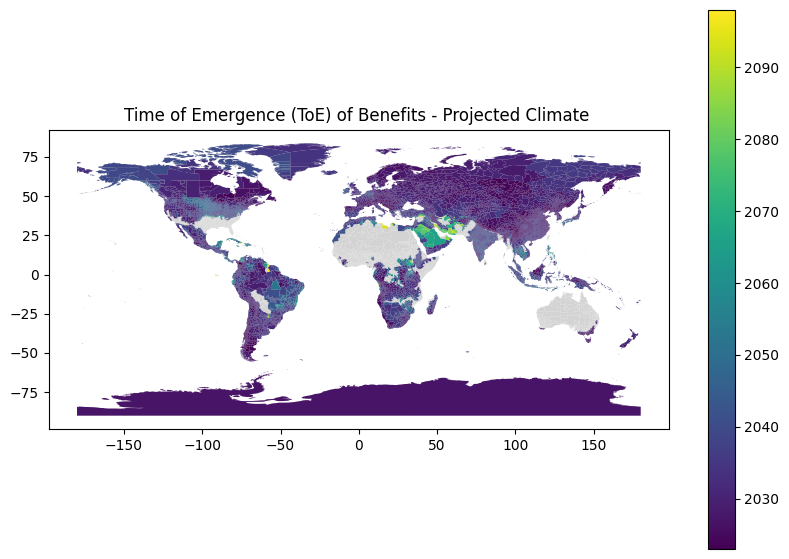

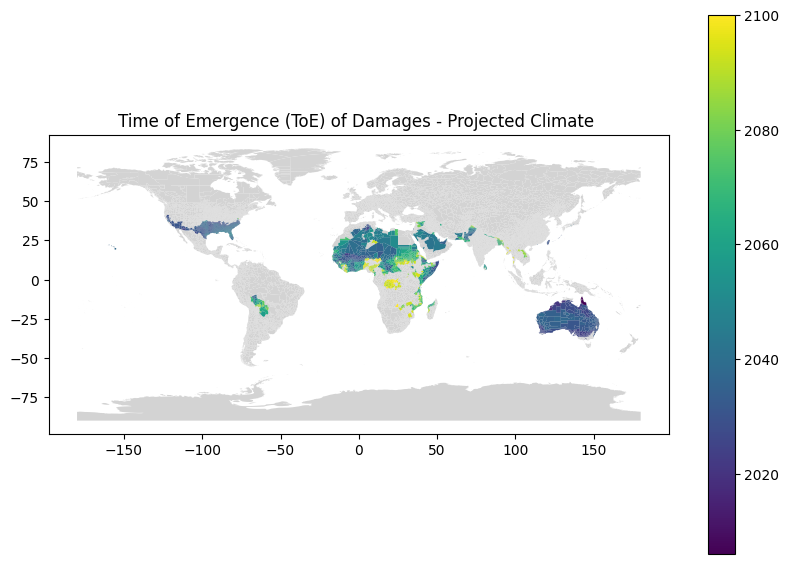

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 7))
TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - Projected Climate ")

fig, ax2 = plt.subplots(figsize=(10, 7))
TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - Projected Climate ")


In [63]:
output_damages_shapefile_path = "/projects/kopp/dtb96/branches/Mortality_Project/notebooks/TOE_Damages.shp"

# Create the directory if it does not exist
output_damages_directory = os.path.dirname(output_damages_shapefile_path)
os.makedirs(output_damages_directory, exist_ok=True)

# Export the GeoDataFrame to a shapefile
TOE_sf_24k_merged[['geometry', 'TOE_Damages']].to_file(output_damages_shapefile_path, driver='ESRI Shapefile')

/tmp/ipykernel_29117/3755167560.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  TOE_sf_24k_merged[['geometry', 'TOE_Damages']].to_file(output_damages_shapefile_path, driver='ESRI Shapefile')


## TOE of Benefits and Damages Historical Climate Global Map

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - Projected Historical Climate ')

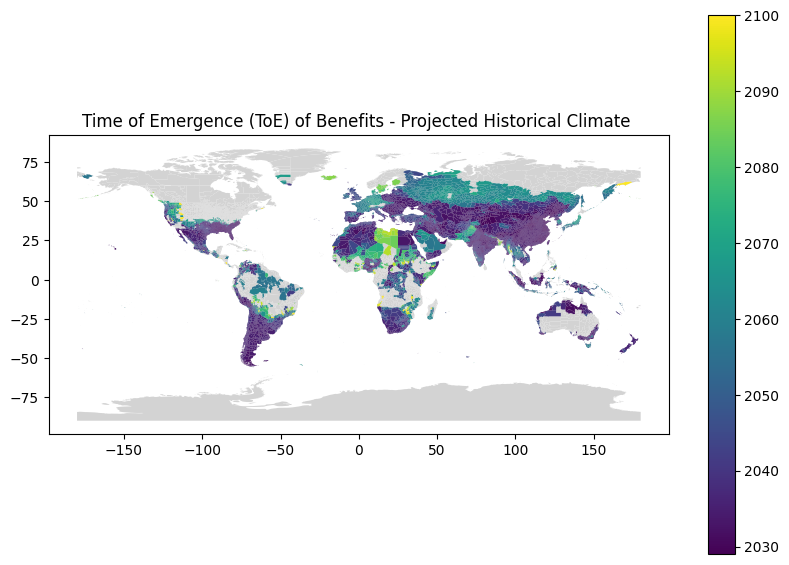

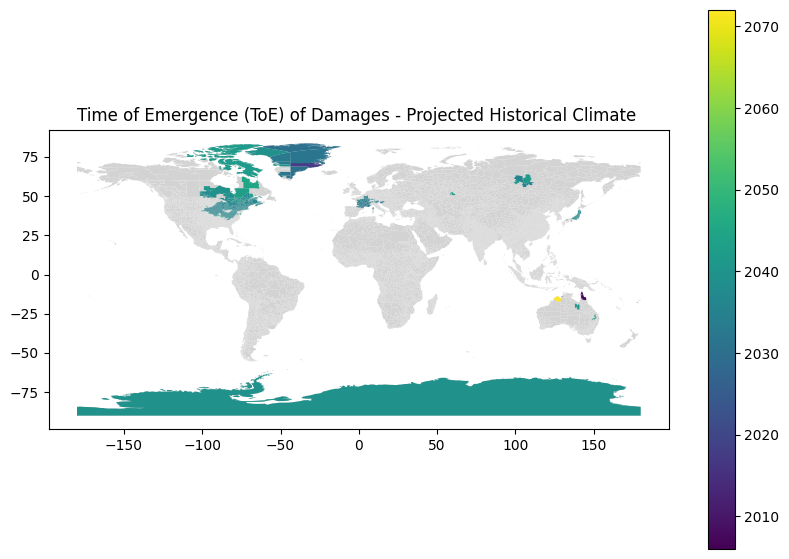

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
histclim_TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - Projected Historical Climate ")

fig, ax2 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
histclim_TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - Projected Historical Climate ")


## TOE of Benefits and Damages Difference (Full Adaptation - Historical Climate) Global Maps:

Text(0.5, 1.0, 'Time of Emergence (ToE) of Damages - Simple Difference w/ Projected Historical Climate ')

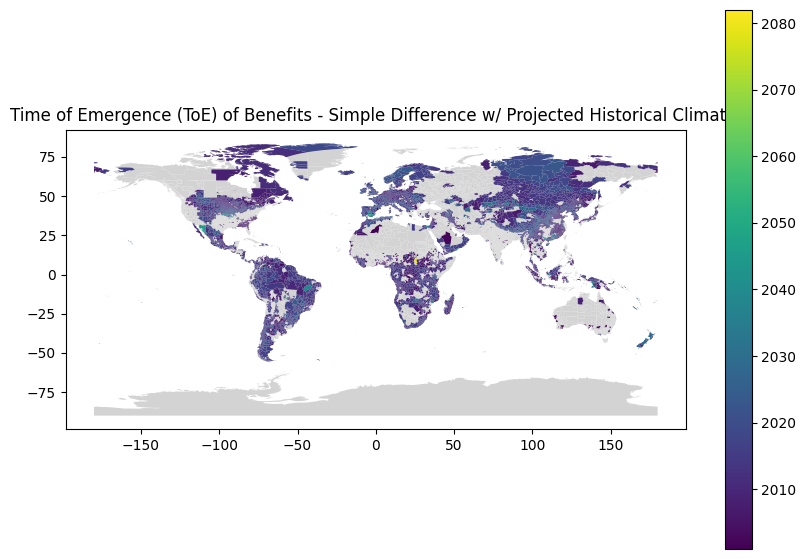

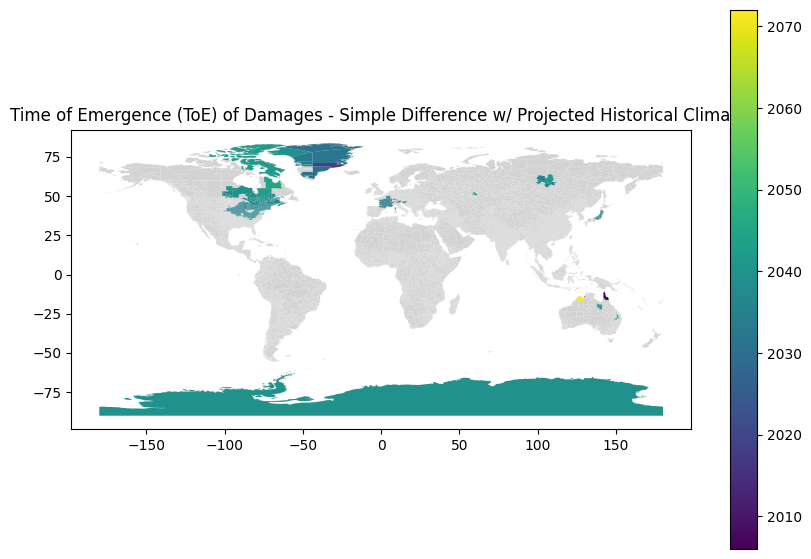

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 7))
simple_difference_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax1)
simple_difference_TOE_sf_24k_merged.plot(column='TOE_Benefits', cmap='viridis', legend=True, ax=ax1)
ax1.set_title("Time of Emergence (ToE) of Benefits - Simple Difference w/ Projected Historical Climate ")

fig, ax2 = plt.subplots(figsize=(10, 7))
histclim_TOE_sf_24k_merged.plot(color ='lightgrey', ax=ax2)
histclim_TOE_sf_24k_merged.plot(column='TOE_Damages', cmap='viridis', legend=True, ax=ax2)
ax2.set_title("Time of Emergence (ToE) of Damages - Simple Difference w/ Projected Historical Climate ")
#### change title format

## Categorizing Regions by Type of Time of Emergence

In this section, we categorize regions based on whether the time of emergence (ToE) for climate benefits or damages is delayed, accelerated, or does not occur. This categorization helps to identify which regions are experiencing changes in the timing of benefits and/or damages due to climate change.

### Explanation

1. **Calculate Differences**:
   Calculate the difference in ToE for benefits between two scenarios (e.g., a future scenario and a historical scenario).

2. **Create a DataFrame with Differences**:
   Create a new DataFrame, `TOE_Benefits_diff_df`, that retains essential columns and includes the calculated differences.

3. **Initialize Lists for Categorization**:
   Initialize empty lists to store regions based on their ToE categorization.

4. **Categorize Regions**:
   Iterate through the DataFrame and append regions to the appropriate list based on the ToE differences:
   Delay of Emergence of Benefits
   Acceleration of Emergence of Benefits
   Delay of Emergence of Damages
   Acceleration of Emergence of Damages
   Emergence of both Benefits and Damages
   No Emergence occurs
 
6. **Convert Lists to DataFrames**:
   Convert the lists to DataFrames for easier manipulation and analysis.

## Column definitions
  - **gadmid**: Unique geodata identifier for each region.
  - **region**: The name or code of the region.
  - **ISO**: ISO country code.
  - **geometry**: Geospatial data representing the boundaries of the region.
---

## Benefits (Delayed, Accelerated, No Emergence):

In [34]:
TOE_Benefits_diff = TOE_sf_24k_merged['TOE_Benefits'] - histclim_TOE_sf_24k_merged['TOE_Benefits']

# Create the new DataFrame 'A' with the retained columns and the calculated differences
TOE_Benefits_diff_df = TOE_sf_24k_merged[['gadmid', 'region', 'ISO', 'geometry']].copy()
TOE_Benefits_diff_df['TOE_Benefits_Diff'] = TOE_Benefits_diff

TOE_Benefits_diff_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
0,28115,CAN.1.2.28,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN
1,28116,CAN.1.17.403,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN
2,28119,CAN.2.34.951,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN
3,28120,CAN.11.259.4274,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",-6.0
24374,6902,BWA.7,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",-4.0
24375,6915,BWA.6.16,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",-8.0
24376,6909,BWA.5,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",-3.0


In [35]:
TOE_Benefits_delayed = []
TOE_Benefits_accelerated = []
no_Benefits_emergence = []

# Iterate through the DataFrame and append to the appropriate list
for index, row in TOE_Benefits_diff_df.iterrows():
    if pd.isna(row['TOE_Benefits_Diff']):
        no_Benefits_emergence.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])
    elif row['TOE_Benefits_Diff'] > 0:
        TOE_Benefits_delayed.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])
    elif row['TOE_Benefits_Diff'] < 0:
        TOE_Benefits_accelerated.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Benefits_Diff']])

# Convert lists to DataFrames for easier manipulation if needed
TOE_Benefits_delayed_df = pd.DataFrame(TOE_Benefits_delayed)
TOE_Benefits_accelerated_df = pd.DataFrame(TOE_Benefits_accelerated)
no_Benefits_emergence_df = pd.DataFrame(no_Benefits_emergence)


## Acceleration of Climate Benefits

The dataset `TOE_Benefits_accelerated_df` contains information about regions where the time of emergence (ToE) for climate benefits is accelerated based on the analysis. This means that the conditions for climate benefits are happen sooner in the given timeframe or under the specified scenarios. 

### Usage

This dataset is useful for identifying and analyzing regions where the expected climate benefits materialize faster than in the historical climate scenrio. It can help in understanding the geographical areas that might experience the most potential benefits due to climate change, and can guide further investigation into the reasons behind the cause for this.

---

In [36]:
TOE_Benefits_accelerated_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
15,28155,CAN.2.42.1074,CAN,POLYGON ((-124.6516723632812 49.88142776489263...,-34.0
26,28181,CAN.2.43.1085,CAN,MULTIPOLYGON (((-130.4783325195312 54.41511535...,-43.0
28,28210,CAN.2.43.1089,CAN,"POLYGON ((-130.193359375 54.247505187988395, -...",-49.0
38,28263,CAN.2.36.989,CAN,POLYGON ((-127.04244232177729 50.5875015258788...,-39.0
119,28472,CAN.2.36.981,CAN,POLYGON ((-127.41435241699219 50.6955566406250...,-38.0
...,...,...,...,...,...
24373,6905,BWA.1,BWA,POLYGON ((26.01722908020031 -23.55864906311023...,-6.0
24374,6902,BWA.7,BWA,POLYGON ((22.50413322448736 -18.11382102966303...,-4.0
24375,6915,BWA.6.16,BWA,POLYGON ((27.28497123718273 -20.49781227111810...,-8.0
24376,6909,BWA.5,BWA,POLYGON ((23.05666923522955 -23.31138992309564...,-3.0


## Delayed Emergence of Climate Benefits

The dataset `TOE__Benefits_delayed_df` contains information about regions where the time of emergence (ToE) for climate benefits is delayed based on the analysis. This indicates that the benefits are expected to occur later than initially projected or observed under historical scenarios.


In [37]:
TOE_Benefits_delayed_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
1018,26518,KHM.17.112.1024.1027,KHM,POLYGON ((104.18445587158209 12.73460102081298...,13.0
1019,26565,KHM.17.111.1013.1016,KHM,POLYGON ((103.95899200439453 12.81017017364502...,13.0
1020,27118,KHM.17.110.1002.1005,KHM,POLYGON ((103.89933013916021 13.05836105346708...,10.0
1021,27214,KHM.17.113.1029.1032,KHM,POLYGON ((103.79183959960949 12.49050140380853...,12.0
1022,27252,KHM.17.113.1030.1033,KHM,POLYGON ((103.77263641357422 12.39152145385747...,12.0
...,...,...,...,...,...
24350,121374,PRY.14,PRY,POLYGON ((-56.7113418579101 -27.46472930908197...,10.0
24351,121375,PRY.15,PRY,POLYGON ((-57.370044708251896 -27.415540695190...,31.0
24352,121378,PRY.16,PRY,POLYGON ((-57.735881805419865 -26.391143798828...,2.0
24355,121403,PRY.11,PRY,POLYGON ((-56.70982360839838 -25.6590232849121...,10.0


## No Emergence of Climate Benefits

The dataset `no_emergence_df` contains information about regions where the time of emergence (ToE) for climate benefits does not occur based on the analysis. This means that the conditions for climate benefits are not met in the given timeframe or under the specified scenarios. 

---

In [38]:
no_Benefits_emergence_df

,gadmid,region,ISO,geometry,TOE_Benefits_Diff
0,28115,CAN.1.2.28,CAN,POLYGON ((-110.0545883178711 53.30730056762695...,NaN
1,28116,CAN.1.17.403,CAN,POLYGON ((-111.23054504394526 52.9194259643554...,NaN
2,28119,CAN.2.34.951,CAN,POLYGON ((-127.68527221679688 55.2957000732422...,NaN
3,28120,CAN.11.259.4274,CAN,POLYGON ((-77.73079681396479 55.31879043579118...,NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.2593994140625 54.99974822998058,...",NaN
...,...,...,...,...,...
24361,121423,PRY.3,PRY,POLYGON ((-55.53572463989258 -23.5349788665770...,NaN
24362,121399,PRY.1,PRY,POLYGON ((-57.988670349121094 -22.080915451049...,NaN
24366,121398,PRY.5,PRY,POLYGON ((-60.799396514892464 -23.871873855590...,NaN
24367,83365,GUF.2,GUF,POLYGON ((-53.33477401733393 2.284413099288940...,NaN


In [39]:
histclim_TOE_sf_24k_merged

,gadmid,region,color,ISO,geometry,TOE_Damages,TOE_Benefits
0,28115,CAN.1.2.28,1,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN,NaN
1,28116,CAN.1.17.403,2,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN,NaN
2,28119,CAN.2.34.951,3,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN,NaN
3,28120,CAN.11.259.4274,4,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN,NaN
4,28124,CAN.11.269.4448,5,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",2043.0,NaN
...,...,...,...,...,...,...,...
24373,6905,BWA.1,24374,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN,2041.0
24374,6902,BWA.7,24375,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN,2042.0
24375,6915,BWA.6.16,24376,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN,2042.0
24376,6909,BWA.5,24377,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN,2041.0


## Plotting TOE Benefits Difference Map

In this section we convert the delayed, accelerated, and no emergence dataframes into geopandas dataframes to plot the categorization of regions onto a global map. The blue shading indicates regions where there is a delay of emergence of benefits (benefits occurring later), with darker shading showing areas of greater delay. The red shadings highlight regions where there is an acceleration in the emergence of benefits (benefits occurring sooner), with darker shading showing areas of g
reater acceleration. The regions in grey are where no emergence of benefits occur. 

/tmp/ipykernel_29117/2159526937.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


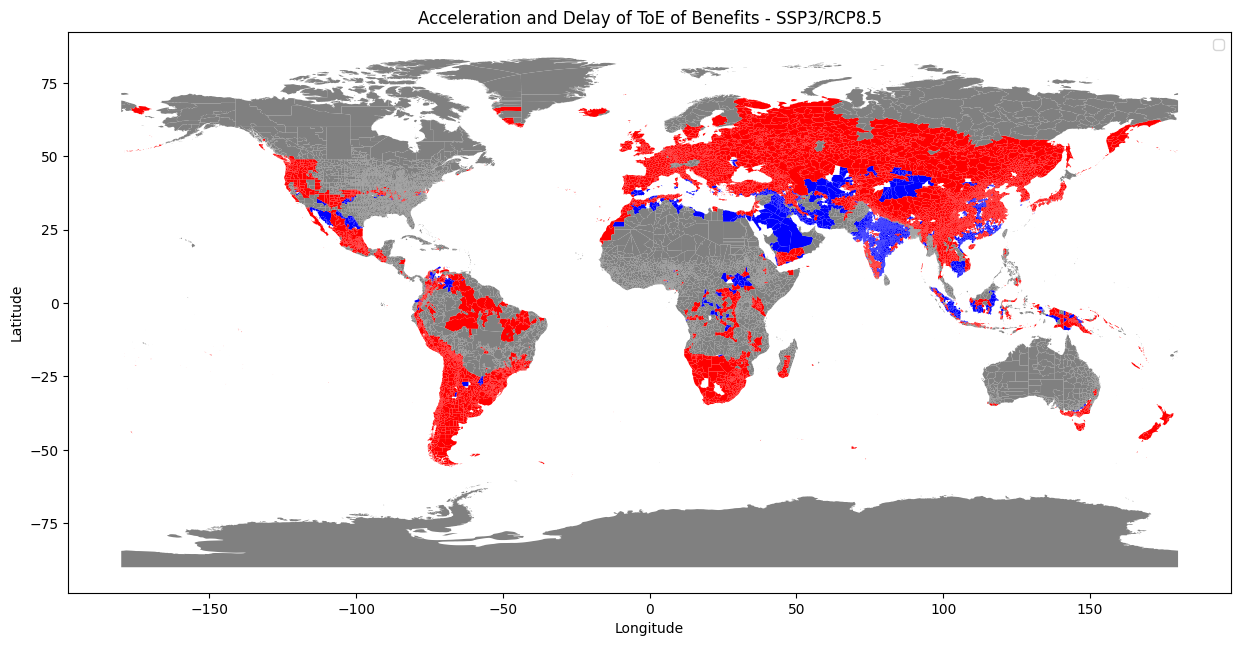

In [40]:
TOE_Benefits_delayed_gdf = geopandas.GeoDataFrame(TOE_Benefits_delayed_df, geometry='geometry')
TOE_Benefits_accelerated_gdf = geopandas.GeoDataFrame(TOE_Benefits_accelerated_df, geometry='geometry')
no_Benefits_emergence_gdf = geopandas.GeoDataFrame(no_Benefits_emergence_df, geometry='geometry')

# Set the coordinate reference system (CRS) if necessary
# Example: TOE_delayed_gdf.crs = "EPSG:4326"  # WGS84

# Plot the GeoDataFrames
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

TOE_Benefits_delayed_gdf.plot(ax=ax, color='blue', label='TOE Delayed')
TOE_Benefits_accelerated_gdf.plot(ax=ax, color='red', label='TOE Accelerated')
no_Benefits_emergence_gdf.plot(ax=ax, color='gray', label='No Emergence')

# Add a legend
plt.legend()

# Add titles and labels
plt.title('Acceleration and Delay of ToE of Benefits - SSP3/RCP8.5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

/tmp/ipykernel_29117/1154094036.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


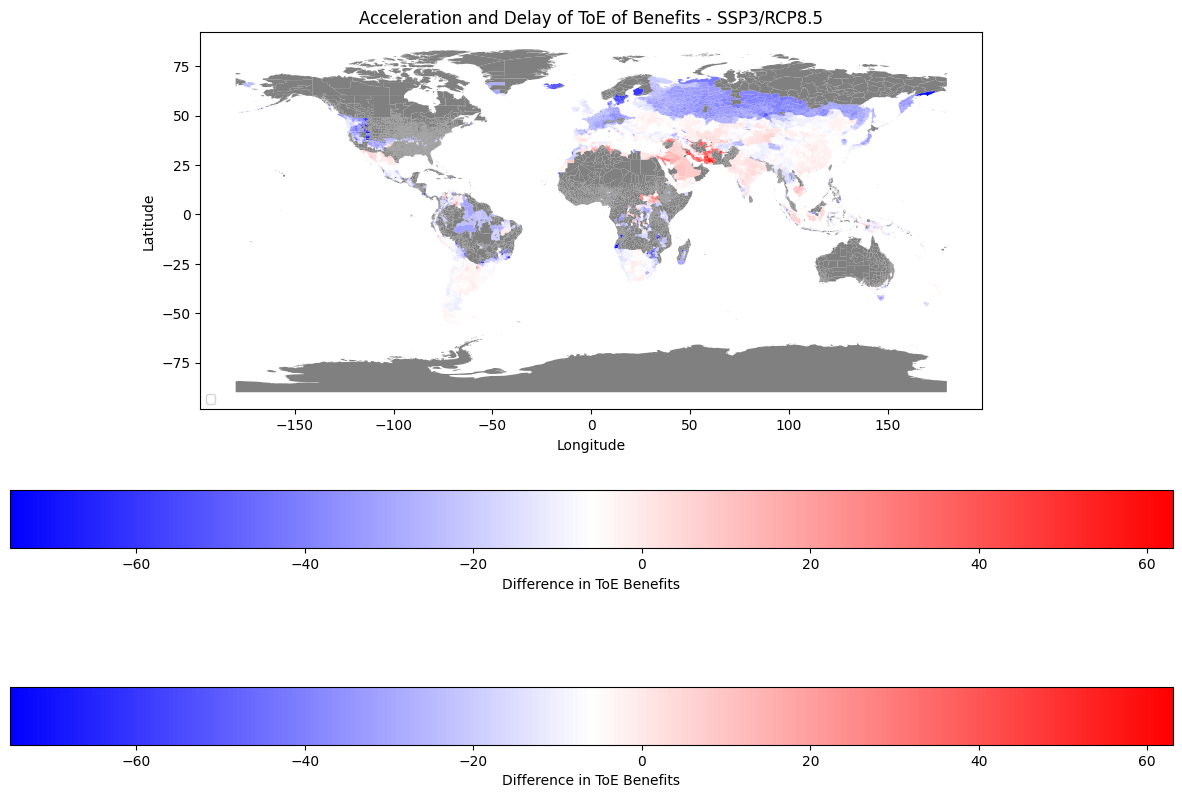

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Convert to GeoDataFrames
TOE_Benefits_delayed_gdf = gpd.GeoDataFrame(TOE_Benefits_delayed_df, geometry='geometry')
TOE_Benefits_accelerated_gdf = gpd.GeoDataFrame(TOE_Benefits_accelerated_df, geometry='geometry')
no_Benefits_emergence_gdf = gpd.GeoDataFrame(no_Benefits_emergence_df, geometry='geometry')

# Combine all data for consistent color mapping
combined_Benefits_gdf = gpd.GeoDataFrame(pd.concat([TOE_Benefits_delayed_gdf, TOE_Benefits_accelerated_gdf], ignore_index=True), geometry='geometry')

# Create a colormap for benefits
cmap_benefits = plt.get_cmap('bwr')
norm_benefits = mcolors.Normalize(vmin=combined_Benefits_gdf['TOE_Benefits_Diff'].min(), vmax=combined_Benefits_gdf['TOE_Benefits_Diff'].max())

# Plot the GeoDataFrames
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot benefits with color mapping
combined_Benefits_gdf.plot(ax=ax, column='TOE_Benefits_Diff', cmap=cmap_benefits, norm=norm_benefits, alpha=1.0, legend=True, legend_kwds={'label': "Difference in ToE Benefits", 'orientation': "horizontal"})

# Plot no emergence regions in gray
no_Benefits_emergence_gdf.plot(ax=ax, color='gray', alpha=1.0, label='No Emergence')

# Add a legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left', fontsize='small')

# Add titles and labels
plt.title('Acceleration and Delay of ToE of Benefits - SSP3/RCP8.5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap_benefits, norm=norm_benefits)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Difference in ToE Benefits')

# Show the plot
plt.show()
###can set limits based on latitude - use this for antarctica, or could mask by population
### use qgis rather than interactive map - export shapefile from map - import in qgis and try to create full interactive
### 



In [65]:
combined_Benefits_gdf['TOE_Benefits_Diff'].max()

63.0

In [42]:
output_shapefile_path = "/projects/kopp/dtb96/branches/Mortality_Project/notebooks/combined_benefits.shp"

# Create the directory if it does not exist
output_directory = os.path.dirname(output_shapefile_path)
os.makedirs(output_directory, exist_ok=True)

# Export the combined Benefits GeoDataFrame to a shapefile
combined_Benefits_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

/tmp/ipykernel_29117/3850254063.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  combined_Benefits_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')


In [43]:
output_shapefile_path = "/path/to/your/output/directory/combined_benefits.shp"
combined_Benefits_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

/tmp/ipykernel_29117/1663119865.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  combined_Benefits_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')


DriverIOError: Failed to create file /path/to/your/output/directory/combined_benefits.shp: No such file or directory

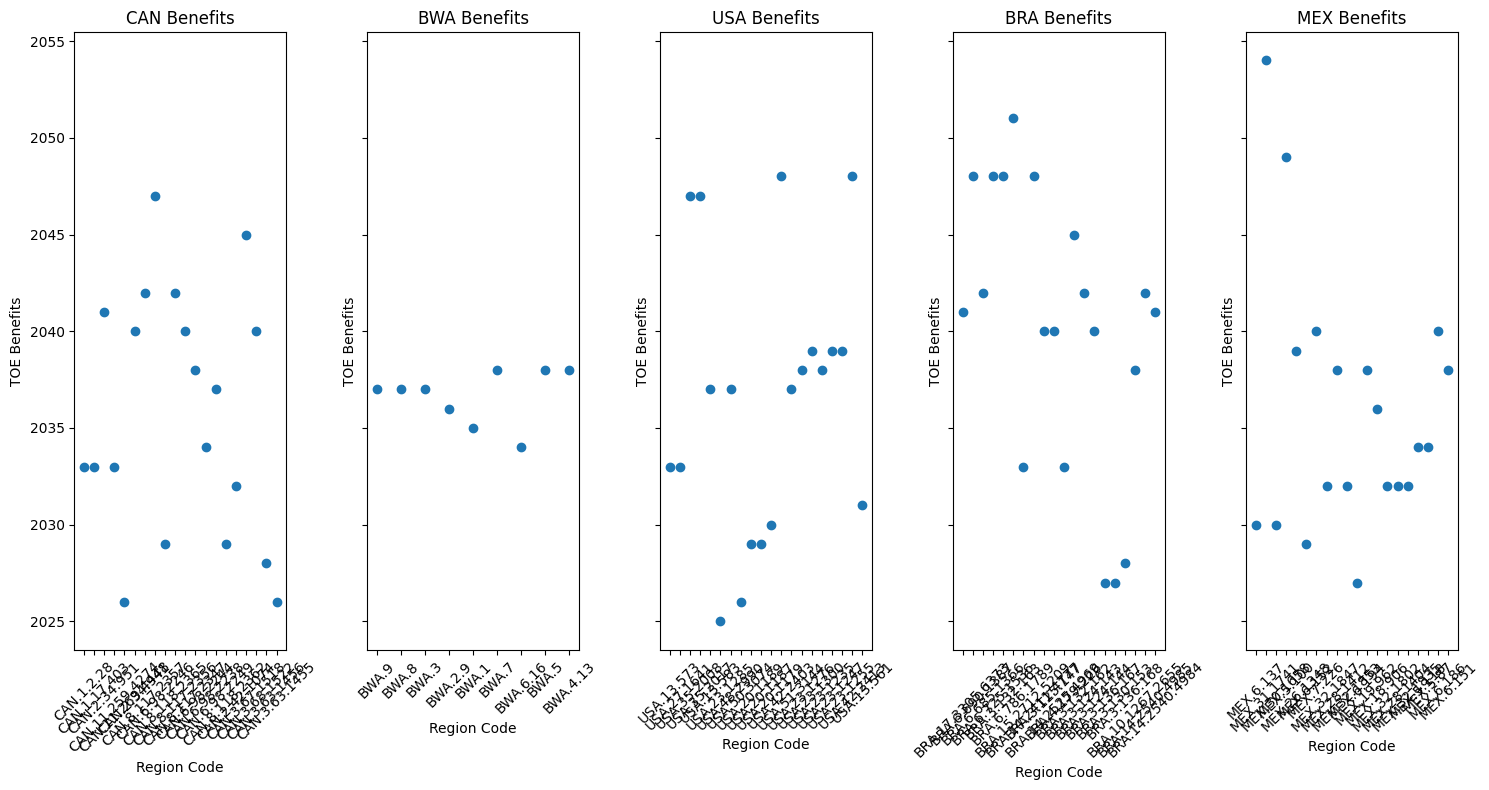

In [44]:
user_region_identifiers = ['CAN', 'BWA', 'USA', 'BRA', 'MEX']  # Add more as needed


fig, axes = plt.subplots(nrows=1, ncols=len(user_region_identifiers), figsize=(15, 8), sharey=True)


for ax, identifier in zip(axes, user_region_identifiers):
    # Filter dataset by the identifier
    filtered_df = TOE_sf_24k_merged[TOE_sf_24k_merged['region'].str.startswith(identifier)]
    
    # Select the first 20 regions
    selected_df = filtered_df.head(20)
    
    # Plot TOE_Benefits for these regions
    ax.scatter(selected_df['region'], selected_df['TOE_Benefits'], label=f'{identifier} Benefits')
    ax.set_title(f'{identifier} Benefits')
    ax.set_xlabel('Region Code')
    ax.set_ylabel('TOE Benefits')
    ax.tick_params(axis='x', rotation=45)

# Customize plot
plt.tight_layout()
plt.show()

In [45]:

# # Define region identifier and number of plots
# region_identifier = 'USA.3'
# num_plots = 10

# # Filter dataset for regions starting with the region_identifier
# filtered_ds = ds.sel(region=[code for code in ds.region.values if code.startswith(region_identifier)])



# emergence_years_damages = extract_emergence_years(TOE_sf_24k_merged, 'TOE_Damages')
# emergence_years_benefits = extract_emergence_years(TOE_sf_24k_merged, 'TOE_Benefits')

# # Define function to plot the data
# def plot_quantiles(region_code, rolling_quantiles, emergence_years_damages, emergence_years_benefits):
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     region_data = rolling_quantiles.sel(region=region_code)
#     raw_data = filtered_ds.sel(region=region_code).to_dataframe().reset_index()
    
#     ax.plot(raw_data['year'], raw_data['rebased'], label=f'{region_code} Raw Data', color='gray', alpha=0.5)
    
#     # Plot quantile high and low
#     ax.plot(region_data['year'], region_data.sel(quantile=quantile_low), label=f'{region_code} Quantile Low', color='blue', alpha=0.7)
#     ax.plot(region_data['year'], region_data.sel(quantile=quantile_high), label=f'{region_code} Quantile High', color='red', alpha=0.7)
    
#     # Plot vertical lines for year of emergence
#     if region_code in emergence_years_damages:
#         ax.axvline(x=emergence_years_damages[region_code], color='green', linestyle='--', label=f'{region_code} Emergence Damages')
#     if region_code in emergence_years_benefits:
#         ax.axvline(x=emergence_years_benefits[region_code], color='orange', linestyle='--', label=f'{region_code} Emergence Benefits')
    
#     # Customize plot
#     # Add horizontal lines at the start of each quantile line
#     ax.axhline(y=region_data.sel(year=region_data['year'].min(), quantile=quantile_low), color='blue', linestyle='--', alpha=0.7)
#     ax.axhline(y=region_data.sel(year=region_data['year'].min(), quantile=quantile_high), color='red', linestyle='--', alpha=0.7)

#     ax.set_title(f'Rolling Quantiles Time Series for {region_code}')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Value')
#     ax.legend()
#     ax.grid(True)
    
#     plt.show()

# # Select a random subset of regions for plotting
# random_regions = np.random.choice(filtered_ds.region.values, num_plots, replace=False)

# # Plot for each of the selected regions
# for region_code in random_regions:
#     # Ensure the region code is present in the TOE_sf_24k_merged dataset before plotting
#     if region_code in TOE_sf_24k_merged['region'].values:
#         plot_quantiles(region_code, rolling_quantiles, emergence_years_damages, emergence_years_benefits)

In [46]:
TOE_sf_24k_merged['TOE_Damages']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
24373   NaN
24374   NaN
24375   NaN
24376   NaN
24377   NaN
Name: TOE_Damages, Length: 24378, dtype: float64

## Acceleration and Delay of Emergence of Damages:

In [47]:
TOE_Damages_diff = TOE_sf_24k_merged['TOE_Damages'] - histclim_TOE_sf_24k_merged['TOE_Damages']

# Create the new DataFrame 'A' with the retained columns and the calculated differences
TOE_Damages_diff_df = TOE_sf_24k_merged[['gadmid', 'region', 'ISO', 'geometry']].copy()
TOE_Damages_diff_df['TOE_Damages_Diff'] = TOE_Damages_diff

TOE_Damages_diff_df


,gadmid,region,ISO,geometry,TOE_Damages_Diff
0,28115,CAN.1.2.28,CAN,"POLYGON ((-110.05459 53.30730, -110.00587 53.3...",NaN
1,28116,CAN.1.17.403,CAN,"POLYGON ((-111.23055 52.91943, -111.22076 52.9...",NaN
2,28119,CAN.2.34.951,CAN,"POLYGON ((-127.68527 55.29570, -127.69742 55.3...",NaN
3,28120,CAN.11.259.4274,CAN,"POLYGON ((-77.73080 55.31879, -77.71030 55.317...",NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.25940 54.99975, -65.24999 55.000...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,"POLYGON ((26.01723 -23.55865, 25.86139 -23.355...",NaN
24374,6902,BWA.7,BWA,"POLYGON ((22.50413 -18.11382, 22.98841 -18.018...",NaN
24375,6915,BWA.6.16,BWA,"POLYGON ((27.28497 -20.49781, 27.35821 -20.473...",NaN
24376,6909,BWA.5,BWA,"POLYGON ((23.05667 -23.31139, 23.55222 -23.313...",NaN


In [48]:
TOE_Damages_delayed = []
TOE_Damages_accelerated = []
no_Damages_emergence = []

# Iterate through the DataFrame and append to the appropriate list
for index, row in TOE_Damages_diff_df.iterrows():
    if pd.isna(row['TOE_Damages_Diff']):
        no_Damages_emergence.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])
    elif row['TOE_Damages_Diff'] > 0:
        TOE_Damages_delayed.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])
    elif row['TOE_Damages_Diff'] < 0:
        TOE_Damages_accelerated.append(row[['gadmid', 'region', 'ISO', 'geometry', 'TOE_Damages_Diff']])

# Convert lists to DataFrames for easier manipulation if needed
TOE_Damages_delayed_df = pd.DataFrame(TOE_Damages_delayed)
TOE_Damages_accelerated_df = pd.DataFrame(TOE_Damages_accelerated)
no_Damages_emergence_df = pd.DataFrame(no_Damages_emergence)


## Acceleration of Climate Damages

The dataset `TOE_Damages_accelerated_df` contains information about regions where the time of emergence (ToE) for climate damages is accelerated. This means that the conditions for climate damages happen sooner in the given timeframe or under the specified scenarios. 

---

In [49]:
TOE_Damages_accelerated_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
11109,203305,USA.21.1210,USA,"POLYGON ((-76.69947814941406 38.4965934753418,...",-8.0
11310,203506,USA.43.2454,USA,POLYGON ((-87.51870727539062 36.33515167236334...,-17.0
11914,204110,USA.18.1068,USA,POLYGON ((-88.48285675048828 37.02584075927746...,-11.0
12366,204562,USA.18.1099,USA,"POLYGON ((-86.6115112304687 36.88296127319336,...",-5.0
12370,204566,USA.47.2883,USA,"POLYGON ((-80.0411987304687 36.79399108886719,...",-7.0
12635,204831,USA.43.2433,USA,POLYGON ((-84.0110473632812 36.272029876708984...,-2.0
13015,205211,USA.47.2874,USA,POLYGON ((-78.06307220458979 37.90560913085937...,-15.0
18054,3529,AUS.11.1392,AUS,MULTIPOLYGON (((128.99969482421886 -15.0663280...,-51.0
18068,3545,AUS.6.846,AUS,POLYGON ((151.6476287841797 -26.91317558288568...,-8.0
18166,3692,AUS.6.547,AUS,POLYGON ((151.2728729248047 -27.14551925659179...,-10.0


## Delayed Emergence of Climate Damages

The dataset `TOE_Damages_delayed_df` contains information about regions where the time of emergence (ToE) for climate damages is delayed. This indicates that the damages are expected to occur later than initially projected or observed under historical scenarios.


In [50]:
TOE_Damages_delayed_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
12352,204548,USA.21.1196,USA,POLYGON ((-76.52837371826172 38.71335983276378...,5.0


## No Emergence of Climate Benefits

The dataset `no_emergence_df` contains information about regions where the time of emergence (ToE) for climate benefits does not occur based on the analysis. This means that the conditions for climate benefits are not met in the given timeframe or under the specified scenarios. 

---

In [51]:
no_Damages_emergence_df

,gadmid,region,ISO,geometry,TOE_Damages_Diff
0,28115,CAN.1.2.28,CAN,POLYGON ((-110.0545883178711 53.30730056762695...,NaN
1,28116,CAN.1.17.403,CAN,POLYGON ((-111.23054504394526 52.9194259643554...,NaN
2,28119,CAN.2.34.951,CAN,POLYGON ((-127.68527221679688 55.2957000732422...,NaN
3,28120,CAN.11.259.4274,CAN,POLYGON ((-77.73079681396479 55.31879043579118...,NaN
4,28124,CAN.11.269.4448,CAN,"POLYGON ((-66.2593994140625 54.99974822998058,...",NaN
...,...,...,...,...,...
24373,6905,BWA.1,BWA,POLYGON ((26.01722908020031 -23.55864906311023...,NaN
24374,6902,BWA.7,BWA,POLYGON ((22.50413322448736 -18.11382102966303...,NaN
24375,6915,BWA.6.16,BWA,POLYGON ((27.28497123718273 -20.49781227111810...,NaN
24376,6909,BWA.5,BWA,POLYGON ((23.05666923522955 -23.31138992309564...,NaN


## Plotting TOE Damages Difference Maps

/tmp/ipykernel_29117/3286900066.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


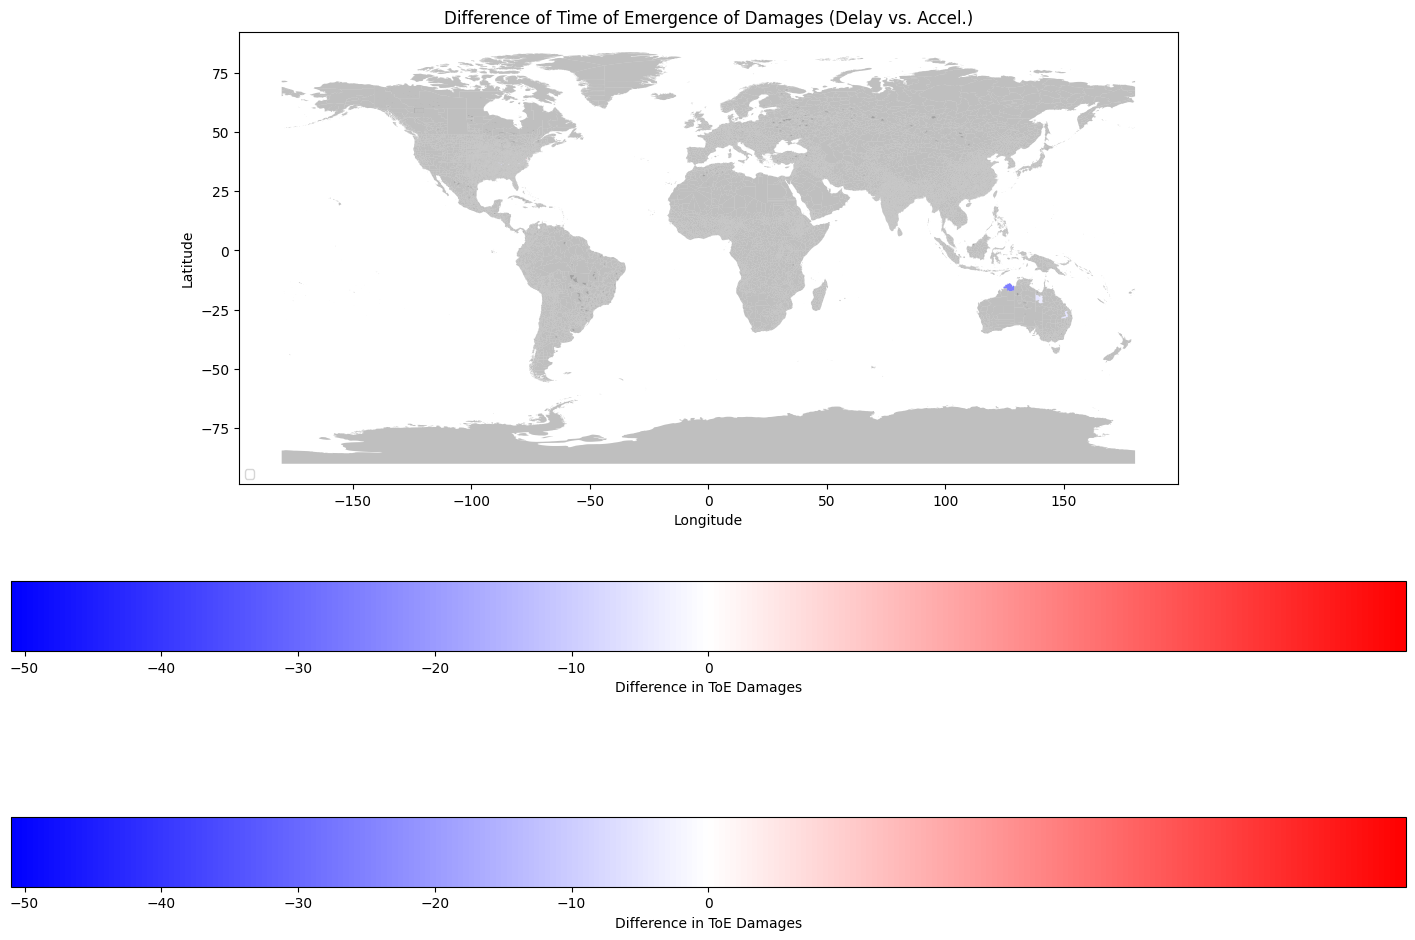

In [52]:
# Convert to GeoDataFrames
TOE_Damages_delayed_gdf = gpd.GeoDataFrame(TOE_Damages_delayed_df, geometry='geometry')
TOE_Damages_accelerated_gdf = gpd.GeoDataFrame(TOE_Damages_accelerated_df, geometry='geometry')
no_Damages_emergence_gdf = gpd.GeoDataFrame(no_Damages_emergence_df, geometry='geometry')

# Combine all data for consistent color mapping
combined_Damages_gdf = gpd.GeoDataFrame(pd.concat([TOE_Damages_delayed_gdf, TOE_Damages_accelerated_gdf], ignore_index=True), geometry='geometry')

# Create a colormap and norm centered on 0 for damages
cmap_damages = plt.get_cmap('bwr')  # Diverging colormap from blue to red
norm_damages = TwoSlopeNorm(vmin=combined_Damages_gdf['TOE_Damages_Diff'].min(), vcenter=0, vmax=combined_Damages_gdf['TOE_Damages_Diff'].max())

# Plot the GeoDataFrames
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

# Plot damages with color mapping
combined_Damages_gdf.plot(ax=ax, column='TOE_Damages_Diff', cmap=cmap_damages, norm=norm_damages, alpha=0.5, legend=True, legend_kwds={'label': "Difference in ToE Damages", 'orientation': "horizontal"})

# Plot no emergence regions in gray
no_Damages_emergence_gdf.plot(ax=ax, color='gray', alpha=0.5, label='No Emergence')

# Add a legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left', fontsize='small')

# Add titles and labels
plt.title('Difference of Time of Emergence of Damages (Delay vs. Accel.)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap_damages, norm=norm_damages)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Difference in ToE Damages')

# Show the plot
plt.show()

In [53]:
# Filter out NaN values
filtered_gdf = combined_Damages_gdf.dropna(subset=['TOE_Damages_Diff'])

# Create lists for positive and negative TOE values
positive_toe_values = []
negative_toe_values = []

# Iterate over the filtered GeoDataFrame and categorize the values
for index, row in filtered_gdf.iterrows():
    if row['TOE_Damages_Diff'] > 0:
        positive_toe_values.append(row['TOE_Damages_Diff'])
    elif row['TOE_Damages_Diff'] < 0:
        negative_toe_values.append(row['TOE_Damages_Diff'])

# Print the lists
print("Positive TOE Damage Differences:", positive_toe_values)
print("Negative TOE Damage Differences:", negative_toe_values)


Positive TOE Damage Differences: [5.0]
Negative TOE Damage Differences: [-8.0, -17.0, -11.0, -5.0, -7.0, -2.0, -15.0, -51.0, -8.0, -10.0, -6.0, -10.0, -7.0, -10.0, -12.0, -10.0, -10.0, -10.0, -14.0]


In [54]:
#2020, 2050 and 2090 snapshots
gdp_2020 = ds_econ['gdp'].sel(year = 2020).to_dataframe().reset_index()
gdp_2050 = ds_econ['gdp'].sel(year = 2050).to_dataframe().reset_index()
gdp_2090 = ds_econ['gdp'].sel(year = 2090).to_dataframe().reset_index()

pop65plus_2020 = ds_econ['pop65plus'].sel(year = 2020).to_dataframe().reset_index()
pop65plus_2050 = ds_econ['pop65plus'].sel(year = 2050).to_dataframe().reset_index()
pop65plus_2090 = ds_econ['pop65plus'].sel(year = 2090).to_dataframe().reset_index()

gdppc_2020 = ds_econ['gdppc'].sel(year = 2020).to_dataframe().reset_index()
gdppc_2050 = ds_econ['gdppc'].sel(year = 2050).to_dataframe().reset_index()
gdppc_2090 = ds_econ['gdppc'].sel(year = 2090).to_dataframe().reset_index()

pop0to4_2020 = ds_econ['pop0to4'].sel(year = 2020).to_dataframe().reset_index()
pop0to4_2050 = ds_econ['pop0to4'].sel(year = 2050).to_dataframe().reset_index()
pop0to4_2090 = ds_econ['pop0to4'].sel(year = 2090).to_dataframe().reset_index()

pop_2020 = ds_econ['pop'].sel(year = 2020).to_dataframe().reset_index()
pop_2050 = ds_econ['pop'].sel(year = 2050).to_dataframe().reset_index()
pop_2090 = ds_econ['pop'].sel(year = 2090).to_dataframe().reset_index()

pop5to64_2020 = ds_econ['pop5to64'].sel(year = 2020).to_dataframe().reset_index()
pop5to64_2050 = ds_econ['pop5to64'].sel(year = 2050).to_dataframe().reset_index()
pop5to64_2090 = ds_econ['pop5to64'].sel(year = 2090).to_dataframe().reset_index()

sf_24k = sf_24k.sort_values("region")


In [55]:
high_model_gdppc_2020 = gdppc_2020[gdppc_2020['model'] == 'high']
high_model_gdppc_2050 = gdppc_2050[gdppc_2050['model'] == 'high']
high_model_gdppc_2090 = gdppc_2050[gdppc_2090['model'] == 'high']

high_model_pop65plus_2020 = pop65plus_2020[pop65plus_2020['model'] == 'high']
high_model_pop65plus_2050 = pop65plus_2050[pop65plus_2050['model'] == 'high']
high_model_pop65plus_2090 = pop65plus_2090[pop65plus_2090['model'] == 'high']

# Display the filtered dataset
print(high_model_pop65plus_2090)

      model                   region   ssp  year      pop65plus
0      high                      ABW  SSP3  2090   38494.487395
1      high                 AFG.1.12  SSP3  2090    6478.412310
2      high  AFG.1.R8abddb145b8788ee  SSP3  2090  141383.809441
3      high  AFG.1.R91a8634efe8e02a7  SSP3  2090   45737.142781
4      high  AFG.1.Ra6a2bba0a271cb4a  SSP3  2090  169912.772832
...     ...                      ...   ...   ...            ...
24373  high                 ZWE.8.43  SSP3  2090   17904.242963
24374  high  ZWE.8.R463b268caaace66f  SSP3  2090   35159.258743
24375  high  ZWE.8.Raef3712f385d02bc  SSP3  2090   19500.860922
24376  high                 ZWE.9.46  SSP3  2090   16855.706158
24377  high  ZWE.9.R19a261b63a503c9c  SSP3  2090   89039.374998

[24378 rows x 5 columns]


In [56]:
sf_24k_econ = sf_24k.copy()

# # Merge all datasets into the new GeoDataFrame 'sf_24k_econ' based on 'region' only
sf_24k_econ = sf_24k_econ.merge(gdp_2020[['region', 'gdp']].rename(columns={'gdp': 'gdp_2020'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(gdp_2050[['region', 'gdp']].rename(columns={'gdp': 'gdp_2050'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(gdp_2090[['region', 'gdp']].rename(columns={'gdp': 'gdp_2090'}), on='region', how='left')

sf_24k_econ = sf_24k_econ.merge(pop65plus_2020[['region', 'pop65plus']].rename(columns={'pop65plus': 'pop65plus_2020'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(pop65plus_2050[['region', 'pop65plus']].rename(columns={'pop65plus': 'pop65plus_2050'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(pop65plus_2090[['region', 'pop65plus']].rename(columns={'pop65plus': 'pop65plus_2090'}), on='region', how='left')

sf_24k_econ = sf_24k_econ.merge(gdppc_2020[['region', 'gdppc']].rename(columns={'gdppc': 'gdppc_2020'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(gdppc_2050[['region', 'gdppc']].rename(columns={'gdppc': 'gdppc_2050'}), on='region', how='left')
sf_24k_econ = sf_24k_econ.merge(gdppc_2090[['region', 'gdppc']].rename(columns={'gdppc': 'gdppc_2090'}), on='region', how='left')

# sf_24k_econ = sf_24k_econ.merge(pop0to4_2020[['region', 'pop0to4']].rename(columns={'pop0to4': 'pop0to4_2020'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop0to4_2050[['region', 'pop0to4']].rename(columns={'pop0to4': 'pop0to4_2050'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop0to4_2090[['region', 'pop0to4']].rename(columns={'pop0to4': 'pop0to4_2090'}), on='region', how='left')

# sf_24k_econ = sf_24k_econ.merge(pop_2020[['region', 'pop']].rename(columns={'pop': 'pop_2020'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop_2050[['region', 'pop']].rename(columns={'pop': 'pop_2050'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop_2090[['region', 'pop']].rename(columns={'pop': 'pop_2090'}), on='region', how='left')

# sf_24k_econ = sf_24k_econ.merge(pop5to64_2020[['region', 'pop5to64']].rename(columns={'pop5to64': 'pop5to64_2020'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop5to64_2050[['region', 'pop5to64']].rename(columns={'pop5to64': 'pop5to64_2050'}), on='region', how='left')
# sf_24k_econ = sf_24k_econ.merge(pop5to64_2090[['region', 'pop5to64']].rename(columns={'pop5to64': 'pop5to64_2090'}), on='region', how='left')

sf_24k_econ

,gadmid,region,color,ISO,geometry,gdp_2020,gdp_2050,gdp_2090,pop65plus_2020,pop65plus_2050,pop65plus_2090,gdppc_2020,gdppc_2050,gdppc_2090
0,3360,ABW,1369,ABW,"POLYGON ((-70.05180 12.56486, -70.02236 12.602...",2.539256e+08,7.454374e+08,2.354416e+09,15733.663737,30749.802883,38494.487395,2065.040650,5180.555556,14023.809524
1,3360,ABW,1369,ABW,"POLYGON ((-70.05180 12.56486, -70.02236 12.602...",2.539256e+08,7.454374e+08,2.354416e+09,15733.663737,30749.802883,38494.487395,2065.040650,5180.555556,14023.809524
2,3360,ABW,1369,ABW,"POLYGON ((-70.05180 12.56486, -70.02236 12.602...",2.539256e+08,7.454374e+08,2.354416e+09,15733.663737,30749.802883,38494.487395,2065.040650,5180.555556,14023.809524
3,3360,ABW,1369,ABW,"POLYGON ((-70.05180 12.56486, -70.02236 12.602...",2.539256e+08,7.454374e+08,2.354416e+09,15733.663737,30749.802883,38494.487395,2065.040650,5180.555556,14023.809524
4,3360,ABW,1369,ABW,"POLYGON ((-70.05180 12.56486, -70.02236 12.602...",2.539256e+08,7.454374e+08,2.354416e+09,15733.663737,30749.802883,38494.487395,2065.040650,5180.555556,14023.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481531,218237,ZWE.9.R19a261b63a503c9c,22572,ZWE,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082...",8.422271e+07,2.801911e+08,5.313144e+08,29042.892789,38127.987082,89039.374998,501.467040,353.981008,571.441223
12481532,218237,ZWE.9.R19a261b63a503c9c,22572,ZWE,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082...",8.422271e+07,2.801911e+08,5.313144e+08,29042.892789,38127.987082,89039.374998,131.161605,1625.917982,7213.887432
12481533,218237,ZWE.9.R19a261b63a503c9c,22572,ZWE,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082...",8.422271e+07,2.801911e+08,5.313144e+08,29042.892789,38127.987082,89039.374998,131.161605,1625.917982,571.441223
12481534,218237,ZWE.9.R19a261b63a503c9c,22572,ZWE,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082...",8.422271e+07,2.801911e+08,5.313144e+08,29042.892789,38127.987082,89039.374998,131.161605,353.981008,7213.887432


In [57]:
high_model_gddpc_2020_merged_df = pd.merge(high_model_gdppc_2020, sf_24k_econ[['region', 'geometry']], on='region', how='left')
high_model_gddpc_2050_merged_df = pd.merge(high_model_gdppc_2050, sf_24k_econ[['region', 'geometry']], on='region', how='left')
high_model_gddpc_2090_merged_df = pd.merge(high_model_gdppc_2090, sf_24k_econ[['region', 'geometry']], on='region', how='left')

high_model_pop65plus_2020_merged_df = pd.merge(high_model_pop65plus_2020, sf_24k_econ[['region', 'geometry']], on='region', how='left')
high_model_pop65plus_2050_merged_df = pd.merge(high_model_pop65plus_2050, sf_24k_econ[['region', 'geometry']], on='region', how='left')
high_model_pop65plus_2090_merged_df = pd.merge(high_model_pop65plus_2090, sf_24k_econ[['region', 'geometry']], on='region', how='left')

# Convert the merged DataFrame to a GeoDataFrame since it now contains geometries
high_model_gddpc_2020_merged_df = gpd.GeoDataFrame(high_model_gddpc_2020_merged_df, geometry='geometry')
high_model_gddpc_2050_merged_df = gpd.GeoDataFrame(high_model_gddpc_2050_merged_df, geometry='geometry')
high_model_gddpc_2090_merged_df = gpd.GeoDataFrame(high_model_gddpc_2090_merged_df, geometry='geometry')

high_model_pop65plus_2020_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2020_merged_df, geometry='geometry')
high_model_pop65plus_2050_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2050_merged_df, geometry='geometry')
high_model_pop65plus_2090_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2090_merged_df, geometry='geometry')

high_model_pop65plus_2090_merged_df



,model,region,ssp,year,pop65plus,geometry
0,high,ABW,SSP3,2090,38494.487395,"POLYGON ((-70.05180 12.56486, -70.02236 12.602..."
1,high,ABW,SSP3,2090,38494.487395,"POLYGON ((-70.05180 12.56486, -70.02236 12.602..."
2,high,ABW,SSP3,2090,38494.487395,"POLYGON ((-70.05180 12.56486, -70.02236 12.602..."
3,high,ABW,SSP3,2090,38494.487395,"POLYGON ((-70.05180 12.56486, -70.02236 12.602..."
4,high,ABW,SSP3,2090,38494.487395,"POLYGON ((-70.05180 12.56486, -70.02236 12.602..."
...,...,...,...,...,...,...
12481531,high,ZWE.9.R19a261b63a503c9c,SSP3,2090,89039.374998,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082..."
12481532,high,ZWE.9.R19a261b63a503c9c,SSP3,2090,89039.374998,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082..."
12481533,high,ZWE.9.R19a261b63a503c9c,SSP3,2090,89039.374998,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082..."
12481534,high,ZWE.9.R19a261b63a503c9c,SSP3,2090,89039.374998,"POLYGON ((29.73844 -21.02485, 29.76323 -21.082..."


In [71]:
# Display the merged GeoDataFrame
high_model_gdppc_2020_merged_df = high_model_gddpc_2020_merged_df.drop_duplicates(subset='region', keep='first')
high_model_gdppc_2050_merged_df = high_model_gddpc_2050_merged_df.drop_duplicates(subset='region', keep='first')
high_model_gdppc_2090_merged_df = high_model_gddpc_2090_merged_df.drop_duplicates(subset='region', keep='first')

high_model_pop65plus_2020_merged_df = high_model_pop65plus_2020_merged_df.drop_duplicates(subset='region', keep='first')
high_model_pop65plus_2050_merged_df = high_model_pop65plus_2050_merged_df.drop_duplicates(subset='region', keep='first')
high_model_pop65plus_2090_merged_df = high_model_pop65plus_2090_merged_df.drop_duplicates(subset='region', keep='first')

# Display the cleaned GeoDataFrame without duplicate regions
print(high_model_gdppc_2020_merged_df)


         model                   region   ssp  year        gdppc  \
0         high                      ABW  SSP3  2020  2065.040650   
512       high                 AFG.1.12  SSP3  2020  1358.426261   
1024      high  AFG.1.R8abddb145b8788ee  SSP3  2020  1358.446605   
1536      high  AFG.1.R91a8634efe8e02a7  SSP3  2020  1358.439220   
2048      high  AFG.1.Ra6a2bba0a271cb4a  SSP3  2020  1359.118374   
...        ...                      ...   ...   ...          ...   
12478976  high                 ZWE.8.43  SSP3  2020   500.885326   
12479488  high  ZWE.8.R463b268caaace66f  SSP3  2020   500.914204   
12480000  high  ZWE.8.Raef3712f385d02bc  SSP3  2020   502.734644   
12480512  high                 ZWE.9.46  SSP3  2020   502.281624   
12481024  high  ZWE.9.R19a261b63a503c9c  SSP3  2020   501.467040   

                                                   geometry  
0         POLYGON ((-70.05180 12.56486, -70.02236 12.602...  
512       POLYGON ((74.89049 37.23569, 74.80614 37.21378...

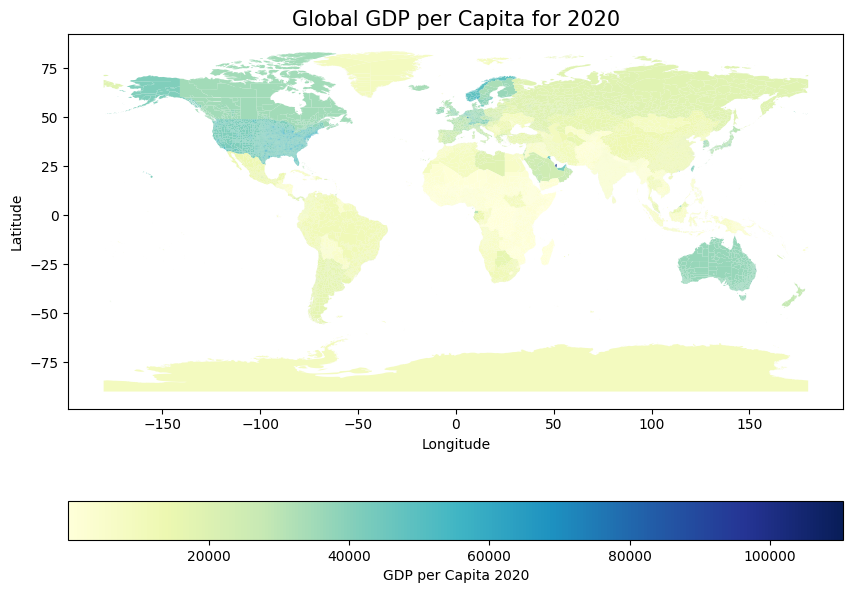

In [59]:
high_model_gdppc_2020_merged_df = gpd.GeoDataFrame(high_model_gdppc_2020_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'gdppc' column (GDP per capita)
high_model_gdppc_2020_merged_df.plot(column='gdppc', cmap='YlGnBu', legend=True, ax=ax,
                                 legend_kwds={'label': "GDP per Capita 2020", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global GDP per Capita for 2020", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

##fi

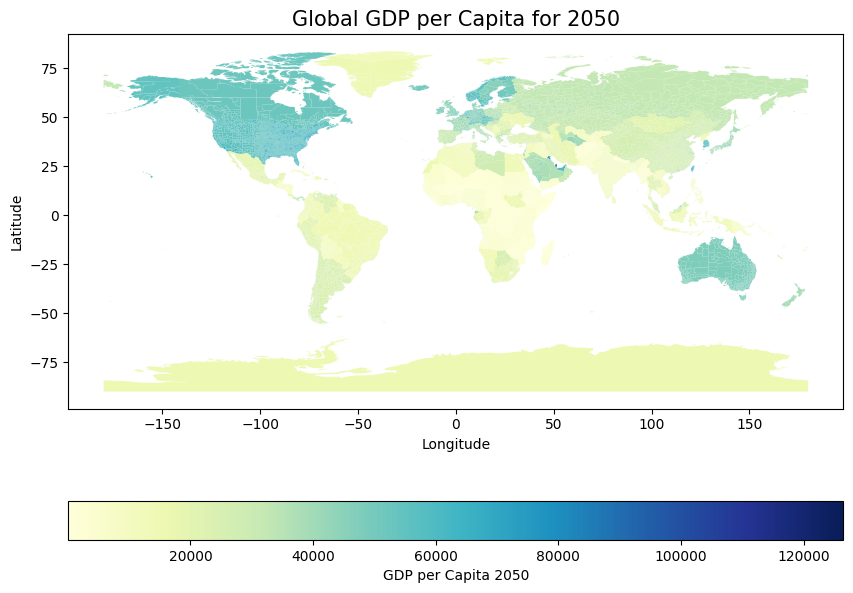

In [60]:
high_model_gdppc_2050_merged_df = gpd.GeoDataFrame(high_model_gdppc_2050_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'gdppc' column (GDP per capita)
high_model_gdppc_2050_merged_df.plot(column='gdppc', cmap='YlGnBu', legend=True, ax=ax,
                                 legend_kwds={'label': "GDP per Capita 2050", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global GDP per Capita for 2050", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

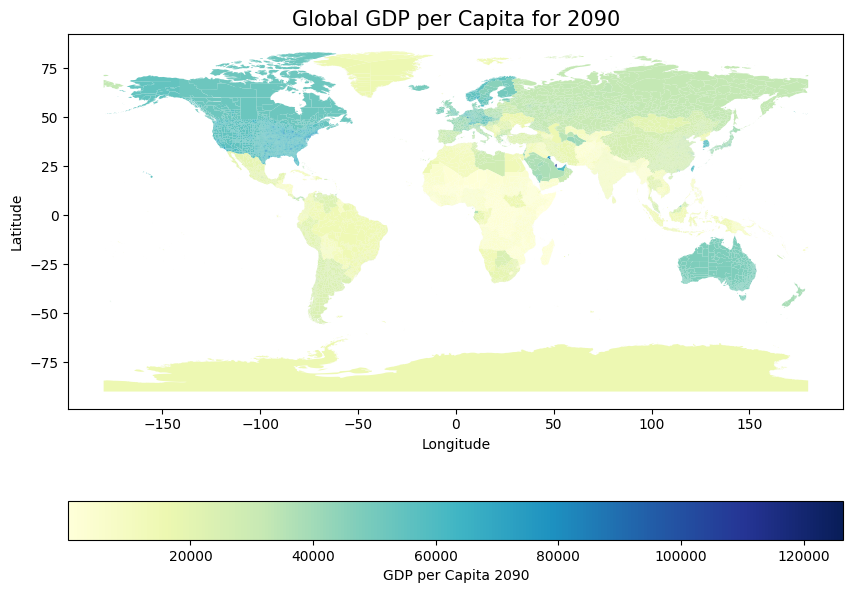

In [61]:
high_model_gdppc_2090_merged_df = gpd.GeoDataFrame(high_model_gdppc_2090_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'gdppc' column (GDP per capita)
high_model_gdppc_2090_merged_df.plot(column='gdppc', cmap='YlGnBu', legend=True, ax=ax,
                                 legend_kwds={'label': "GDP per Capita 2090", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global GDP per Capita for 2090", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

##fix color bar to match

In [75]:
high_model_gdppc_2020_merged_df['percent_gdppc_growth'] = ((high_model_gdppc_2090_merged_df['gdppc'] / high_model_gdppc_2020_merged_df['gdppc']) ** (1 / 70) - 1) * 100  # Convert to percentage

# Show the updated GeoDataFrame with the new growth rate column
print(high_model_gdppc_2020_merged_df[['region','percent_gdppc_growth']].head())


                       region  percent_gdppc_growth
0                         ABW              1.322616
512                  AFG.1.12              0.964220
1024  AFG.1.R8abddb145b8788ee              0.964220
1536  AFG.1.R91a8634efe8e02a7              0.964220
2048  AFG.1.Ra6a2bba0a271cb4a              0.964220


/home/dtb96/.conda/envs/myenv1/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


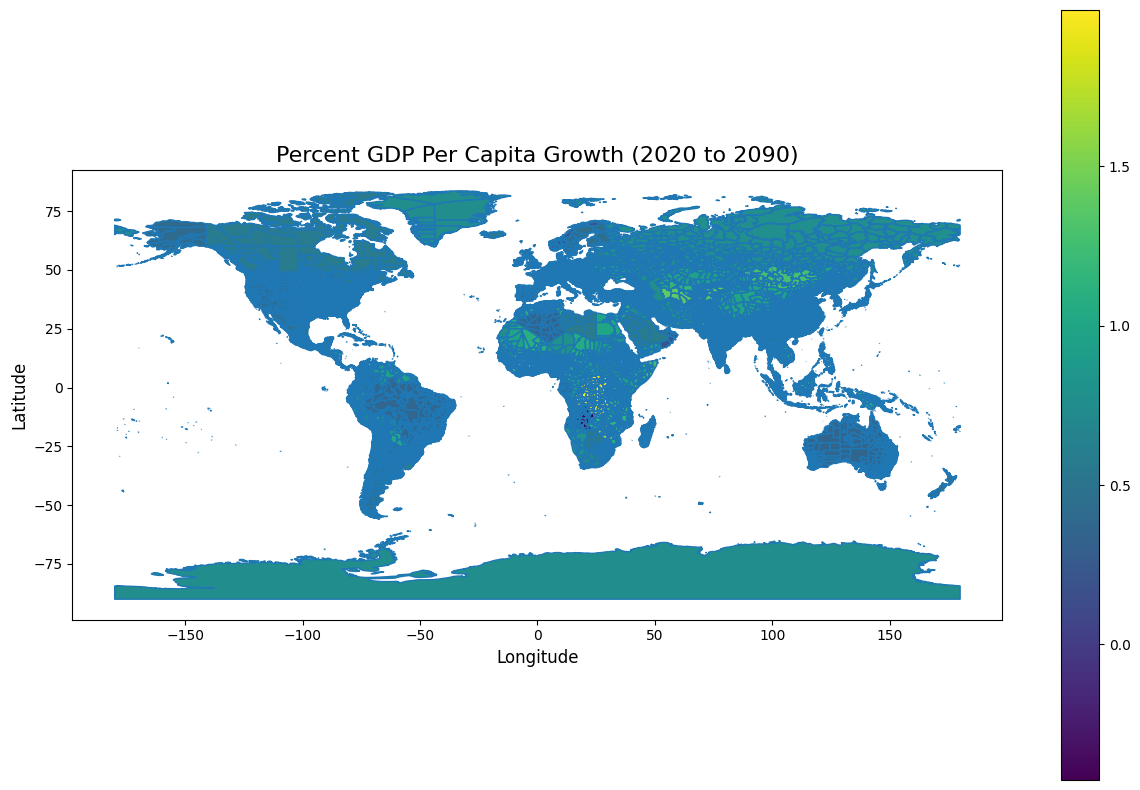

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
high_model_gdppc_2020_merged_df.boundary.plot(ax=ax, linewidth=1)  # Plot boundaries
high_model_gdppc_2020_merged_df.plot(column='percent_gdppc_growth', ax=ax, legend=True,
                                      cmap='viridis',  # Change colormap as needed
                                      missing_kwds={
                                          "color": "lightgrey",
                                          "edgecolor": "black",
                                          "hatch": "xx",
                                          "label": "Missing values"
                                      })

# Add title and labels
ax.set_title('Percent GDP Per Capita Growth (2020 to 2090)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()

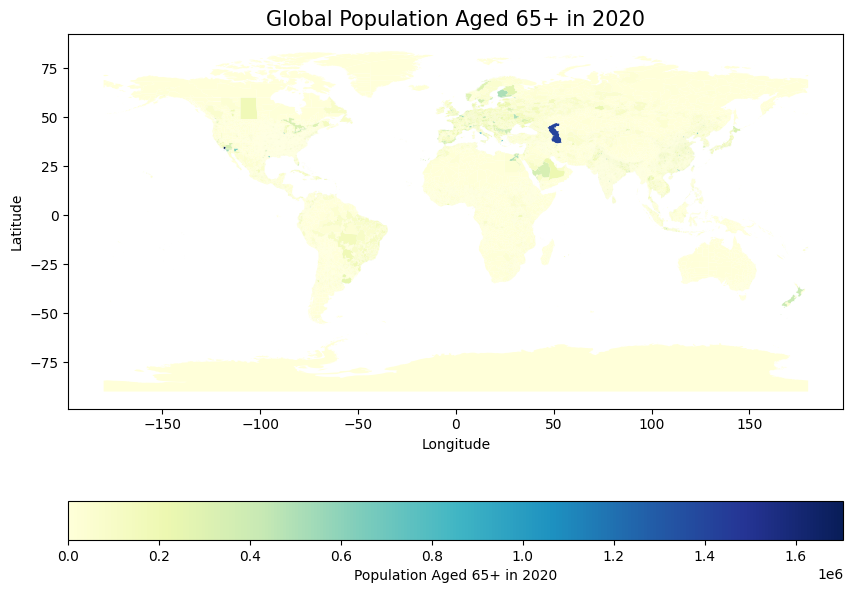

In [77]:
high_model_pop65plus_2020_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2020_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'Population' column
high_model_pop65plus_2020_merged_df.plot(column='pop65plus', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2020", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population Aged 65+ in 2020", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

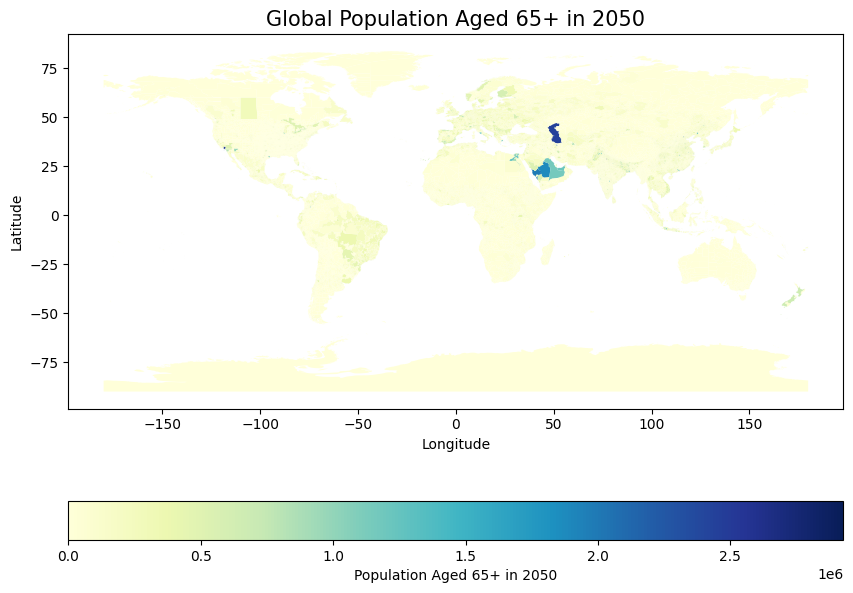

In [78]:
high_model_pop65plus_2050_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2050_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'Population' column
high_model_pop65plus_2050_merged_df.plot(column='pop65plus', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2050", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population Aged 65+ in 2050", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

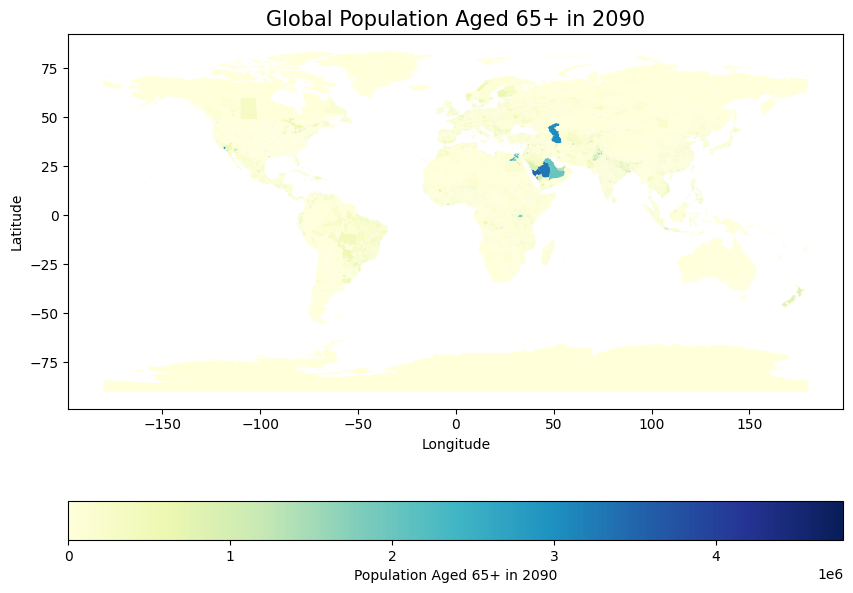

In [79]:
high_model_pop65plus_2090_merged_df = gpd.GeoDataFrame(high_model_pop65plus_2090_merged_df, geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame, coloring regions by the 'Population' column
high_model_pop65plus_2090_merged_df.plot(column='pop65plus', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2090", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population Aged 65+ in 2090", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

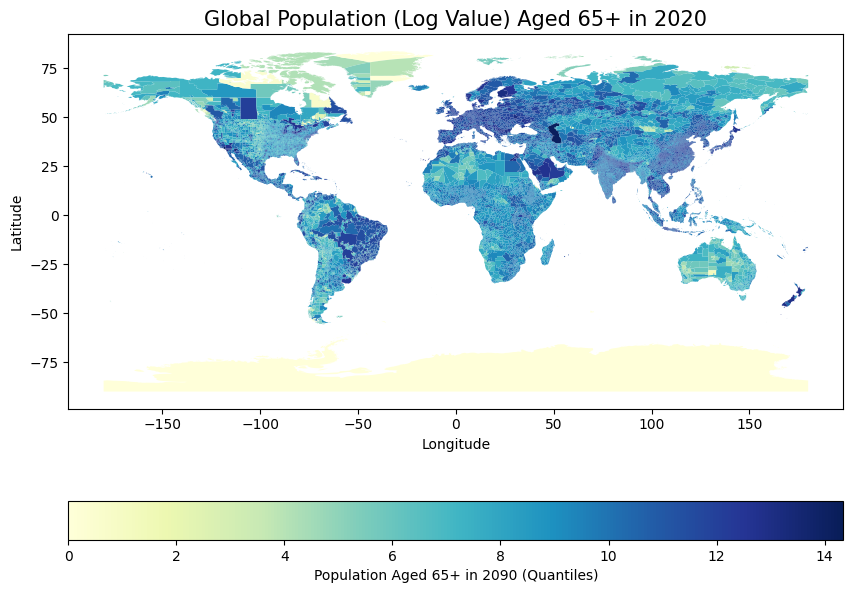

In [80]:

# Apply a log transformation to the 'Population' column
high_model_pop65plus_2020_merged_df['Log_Population'] = np.log1p(high_model_pop65plus_2020_merged_df['pop65plus'])

# Optionally, categorize the log-transformed population into quantiles
high_model_pop65plus_2020_merged_df['Population_Quantile'] = pd.qcut(high_model_pop65plus_2020_merged_df['Log_Population'], q=5, labels=False)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame using quantiles for coloring
high_model_pop65plus_2020_merged_df.plot(column='Log_Population', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2090 (Quantiles)", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population (Log Value) Aged 65+ in 2020", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
output_shapefile_path_2020 = "/projects/kopp/dtb96/branches/Mortality_Project/notebooks/high_model_gdppc_2020_merged_df.shp"

# Create the directory if it does not exist
output_directory_2020 = os.path.dirname(output_shapefile_path_2020)
os.makedirs(output_directory_2020, exist_ok=True)

# Export the GeoDataFrame to a shapefile
high_model_pop65plus_2020_merged_df.to_file(output_shapefile_path_2020, driver='ESRI Shapefile')

In [ ]:

# Apply a log transformation to the 'Population' column
high_model_pop65plus_2050_merged_df['Log_Population'] = np.log1p(high_model_pop65plus_2050_merged_df['pop65plus'])

# Optionally, categorize the log-transformed population into quantiles
high_model_pop65plus_2050_merged_df['Population_Quantile'] = pd.qcut(high_model_pop65plus_2050_merged_df['Log_Population'], q=5, labels=False)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame using quantiles for coloring
high_model_pop65plus_2050_merged_df.plot(column='Log_Population', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2090 (Quantiles)", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population (Log Value) Aged 65+ in 2050", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:

# Apply a log transformation to the 'Population' column
high_model_pop65plus_2090_merged_df['Log_Population'] = np.log1p(high_model_pop65plus_2090_merged_df['pop65plus'])

# Optionally, categorize the log-transformed population into quantiles
high_model_pop65plus_2090_merged_df['Population_Quantile'] = pd.qcut(high_model_pop65plus_2090_merged_df['Log_Population'], q=5, labels=False)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the GeoDataFrame using quantiles for coloring
high_model_pop65plus_2090_merged_df.plot(column='Log_Population', cmap='YlGnBu', legend=True, ax=ax,
                                          legend_kwds={'label': "Population Aged 65+ in 2090 (Quantiles)", 'orientation': "horizontal"})

# Add title and labels
ax.set_title("Global Population (Log Value) Aged 65+ in 2090", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
high_model_gdppc_2020_gdf = gpd.GeoDataFrame(high_model_gdppc_2020_merged_df, geometry='geometry')
high_model_gdppc_2090_gdf = gpd.GeoDataFrame(high_model_gdppc_2090_merged_df, geometry='geometry')

# Merge the two GeoDataFrames on a common column (e.g., 'Country')

# Calculate percent difference
high_model_gdppc_2090_merged_df['percent_diff_2020'] = ((high_model_gdppc_2090_gdf['gdppc'] - high_model_gdppc_2020_gdf['gdppc']) / high_model_gdppc_2020_gdf['gdppc']) * 100

# Create a plot
#fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the merged GeoDataFrame with percent difference
#merged_gdf.plot(column='Percent_Difference', cmap='RdYlGn', legend=True, ax=ax)

# Add title and labels
#ax.set_title("Global Percent Difference in GDP per Capita Between 2020 and 2090", fontsize=15)
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")

# Customize the legend
#sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=merged_gdf['Percent_Difference'].min(), vmax=merged_gdf['Percent_Difference'].max()))
#sm.set_array([])
#cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
#cbar.set_label("Percent Difference in GDP per Capita (%)")

# Show the plot
#plt.show()

In [ ]:
high_model_gdppc_2090_merged_df

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure that sf_24k_econ is a GeoDataFrame and contains valid geometries
# Plotting GDPPC for 2020 using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot using GeoPandas, specifying the column for color coding
sf_24k_econ.plot(column='gdppc_2020', cmap='OrRd', legend=True, ax=ax,
                 legend_kwds={'label': "GDP per Capita 2020", 'orientation': "horizontal"})

# Add titles and labels
ax.set_title("Global GDP per Capita 2020", fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
gdppc_sf_24k_merged['GDPPC_Growth_Pct'] = ((gdppc_sf_24k_merged['GDPPC_2090'] - gdppc_sf_24k_merged['GDPPC_2020']) / gdppc_sf_24k_merged['GDPPC_2020']) * 100

# Calculate annualized growth rate
gdppc_sf_24k_merged['Annual_Growth_Rate'] = (gdppc_sf_24k_merged['GDPPC_2090'] / gdppc_sf_24k_merged['GDPPC_2020']) ** (1 / 70) - 1

# Get the min and max values from the annual growth rate
vmin = gdppc_sf_24k_merged['Annual_Growth_Rate'].min()
vmax = gdppc_sf_24k_merged['Annual_Growth_Rate'].max()

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Plot GDPPC 2020
gdppc_sf_24k_merged.plot(column='GDPPC_2020', cmap='OrRd', legend=True, ax=ax[0],
                         legend_kwds={'label': "GDPPC 2020", 'orientation': "horizontal"}, vmin=vmin, vmax=vmax)
ax[0].set_title("GDP per Capita 2020")
ax[0].set_axis_off()

# Plot GDPPC 2090
gdppc_sf_24k_merged.plot(column='GDPPC_2090', cmap='OrRd', legend=True, ax=ax[1],
                         legend_kwds={'label': "GDPPC 2090", 'orientation': "horizontal"}, vmin=vmin, vmax=vmax)
ax[1].set_title("GDP per Capita 2090")
ax[1].set_axis_off()

# Plot Annualized Growth Rate
gdppc_sf_24k_merged.plot(column='Annual_Growth_Rate', cmap='winter', legend=True, ax=ax[2],
                         legend_kwds={'label': "Annual Growth Rate (2020-2090)", 'orientation': "horizontal"}, vmin=vmin, vmax=vmax)
ax[2].set_title("Annualized Growth Rate (2020 - 2090)")
ax[2].set_axis_off()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Find regions that appear in both the benefits and damages columns
common_regions = set(TOE_sf_24k_merged['TOE_Benefits']) & set(TOE_sf_24k_merged['TOE_Damages'])

# Filter the dataframe to only include rows where regions appear in both columns
common_regions_df = TOE_sf_24k_merged[
    TOE_sf_24k_merged['TOE_Benefits'].isin(common_regions) &
    TOE_sf_24k_merged['TOE_Damages'].isin(common_regions)
]

# Determine whether damages or benefits occur first
common_regions_df['priority'] = common_regions_df.apply(
    lambda row: 'Damages' if row['TOE_Damages'] < row['TOE_Benefits'] else 'Benefits',
    axis=1
)

# Convert to GeoDataFrame if not already one
common_regions_gdf = gpd.GeoDataFrame(common_regions_df, geometry='geometry')

# Plot the regions
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot regions where damages occur first in red
common_regions_gdf[common_regions_gdf['priority'] == 'Damages'].plot(
    ax=ax, color='red', label='Damages First'
)

# Plot regions where benefits occur first in blue
common_regions_gdf[common_regions_gdf['priority'] == 'Benefits'].plot(
    ax=ax, color='blue', label='Benefits First'
)

# Add legend, titles, and labels
plt.legend()
plt.title('Regions Where TOE Damages and Benefits Occur')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [ ]:
pop_sf_24k_merged['Pop_Change_Pct'] = ((pop_sf_24k_merged['Pop_2090'] - pop_sf_24k_merged['Pop_2050']) / pop_sf_24k_merged['Pop_2050']) * 100

# Plotting the percentage population change
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Use the new 'Pop_Change_Pct' column for plotting
pop_sf_24k_merged.plot(column='Pop_Change_Pct', ax=ax, legend=True, cmap='RdBu', linewidth=0.8, edgecolor='0.8')

# Add a title
plt.title('Projected Population Percentage Change (2090 - 2050)')

# Show the plot
plt.show()

In [ ]:
#create function that applies to single region, and produces year and categorizations
#loop over each region and contextualize, core function should focus on one times series, then can accumulate the rest of the regions
#apply this function to every region - split the functions up (relative to historical period)
#def categorize_intersections(rebased_qs):
    #categories = {
        #"Climate Change Accelerates Emergence of Development Benefits": [],
        #"Climate Change Leads to Emergence of Benefits": [],
        #"Climate Change Delays Emergence of Development Benefits": [],
        #"Climate Change Leads to Emergence of Harms": [],
        #"Climate Change leads to emergence of benefits": [],
        #"Places where there are two quantile crossings": []

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

#make if statement for crossing here in the subset data, can still run calculation but on a smaller scale 

# Define user input region codes
user_region_codes = ['AUS', 'USA.14']  # Add more codes as needed

# Filter dataset for the given regions
filtered_ds = ds.sel(region=[code for code in ds.region.values if any(code.startswith(region) for region in user_region_codes)])

# Calculate rolling quantiles for filtered data
rolling_quantiles = filtered_ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")
histclim_rolling_quantiles = ds_histclim["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile([quantile_low, quantile_high], skipna=False, dim="tmp")

# Compute the difference
simple_difference_rolling_quantiles = rolling_quantiles - histclim_rolling_quantiles

# Define number of regions to plot
num_regions_to_plot = 10

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(14, 10))

# Get the first `num_regions_to_plot` regions for plotting
for region_code in filtered_ds.region.values[:num_regions_to_plot]:
    region_data = simple_difference_rolling_quantiles.sel(region=region_code)
    
    # Plotting each quantile
    for quantile in [quantile_low, quantile_high]:
        ax.plot(region_data['year'], region_data.sel(quantile=quantile), label=f'{region_code} Quantile {quantile}', alpha=0.7)

# Plot mean and median if required
# For example: ax.plot(...) 

# Customize plot
ax.set_title('Rolling Quantiles Time Series for Selected Regions')
ax.set_xlabel('Year')
ax.set_ylabel('Difference from Historical Climate')
ax.legend()
ax.grid(True)

# Show plot
plt.show()
### make lines 

In [ ]:
import geopandas as gpd
import folium

# Ensure geometries are valid
TOE_sf_24k_merged = TOE_sf_24k_merged[TOE_sf_24k_merged.is_valid]

# Convert GeoDataFrame to WGS84 coordinate reference system (CRS)
TOE_sf_24k_merged = TOE_sf_24k_merged.to_crs(epsg=4326)

# Check that the GeoDataFrame has geometries and properties
print("GeoDataFrame is empty: ", TOE_sf_24k_merged.empty)
print("First few rows of the GeoDataFrame:\n", TOE_sf_24k_merged.head())

# Check for valid geometries in the GeoDataFrame
if TOE_sf_24k_merged.empty or TOE_sf_24k_merged['geometry'].is_empty.any():
    raise ValueError("The GeoDataFrame has empty or invalid geometries.")

# Convert to GeoJSON format
geo_json_data = TOE_sf_24k_merged.to_json()

# Check the GeoJSON structure (first 500 characters)
print("GeoJSON Sample:\n", geo_json_data[:500])

# Create a base Folium map
m = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodb positron')

# Add a GeoJSON layer to the map
geojson_layer = folium.GeoJson(
    geo_json_data,
    name='TOE Data',
    tooltip=folium.GeoJsonTooltip(fields=['region', 'TOE_Benefits', 'TOE_Damages'],
                                  aliases=['Region', 'TOE Benefits', 'TOE Damages'],
                                  localize=True)
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('interactive_map_Benefits.html')

In [ ]:
import geopandas as gpd
import folium

# Ensure geometries are valid

# Convert GeoDataFrame to WGS84 coordinate reference system (CRS)
TOE_sf_24k_merged = TOE_sf_24k_merged.to_crs(epsg=4326)

# Check that the GeoDataFrame has geometries and properties
print("GeoDataFrame is empty: ", TOE_sf_24k_merged.empty)
print("First few rows of the GeoDataFrame:\n", TOE_sf_24k_merged.head())

# Check for valid geometries in the GeoDataFrame
if TOE_sf_24k_merged.empty or TOE_sf_24k_merged['geometry'].is_empty.any():
    raise ValueError("The GeoDataFrame has empty or invalid geometries.")

# Convert to GeoJSON format
geo_json_data = TOE_sf_24k_merged.to_json()

# Check the GeoJSON structure (first 500 characters)
print("GeoJSON Sample:\n", geo_json_data[:500])

# Create a base Folium map
m = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodb positron')

# Add a GeoJSON layer to the map
geojson_layer = folium.GeoJson(
    geo_json_data,
    name='TOE Data',
    tooltip=folium.GeoJsonTooltip(fields=['region', 'TOE_Benefits', 'TOE_Damages'],
                                  aliases=['Region', 'TOE Benefits', 'TOE Damages'],
                                  localize=True)
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('interactive_map_Benefits.html')

In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Load your GeoDataFrame (assumed already loaded as 'TOE_sf_24k_merged')
# Ensure geometries are valid

# Convert GeoDataFrame to WGS84 coordinate reference system (CRS)
TOE_sf_24k_merged = TOE_sf_24k_merged.to_crs(epsg=4326)

# Check that the GeoDataFrame has geometries and properties
print("GeoDataFrame is empty: ", TOE_sf_24k_merged.empty)
print("First few rows of the GeoDataFrame:\n", TOE_sf_24k_merged.head())

# Check for valid geometries in the GeoDataFrame
if TOE_sf_24k_merged.empty or TOE_sf_24k_merged['geometry'].is_empty.any():
    raise ValueError("The GeoDataFrame has empty or invalid geometries.")

# Convert to GeoJSON format
geo_json_data = TOE_sf_24k_merged.to_json()

# Check the GeoJSON structure (first 500 characters)
print("GeoJSON Sample:\n", geo_json_data[:500])

# Filter out rows where TOE_Benefits is NaN or non-numeric
TOE_sf_24k_merged = TOE_sf_24k_merged[TOE_sf_24k_merged['TOE_Benefits'].apply(pd.to_numeric, errors='coerce').notnull()]

# Define the color scale for 'TOE_Benefits' (adjust the colormap as needed)
vmin, vmax = TOE_sf_24k_merged['TOE_Benefits'].min(), TOE_sf_24k_merged['TOE_Benefits'].max()
colormap = plt.get_cmap('YlGnBu')

# Function to normalize and map colors
def get_color(value, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgb = colormap(norm(value))[:3]  # Get RGB values
    return mcolors.rgb2hex(rgb)  # Convert RGB to hex

# Create a base map centered at a specific latitude and longitude
m = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodb positron')

# Add a GeoJSON layer with popups to the map
geojson_layer = folium.GeoJson(
    geo_json_data,
    name='TOE Data',
    style_function=lambda feature: {
        'fillColor': get_color(feature['properties']['TOE_Benefits'], vmin, vmax),
        'color': 'black',  # Boundary line color
        'weight': 0.5,  # Boundary line thickness (reduce this for less visibility)
        'fillOpacity': 0.7,  # Opacity of the fill color
    },
    highlight_function=lambda feature: {
        'weight': 2, 'color': 'blue', 'fillOpacity': 0.9
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['region', 'TOE_Benefits', 'TOE_Damages'],  # Fields from GeoDataFrame
        aliases=['Region', 'TOE Benefits', 'TOE Damages'],  # Displayed aliases
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['region', 'TOE_Benefits', 'TOE_Damages'],  # Fields from GeoDataFrame for popup
        aliases=['Region', 'TOE Benefits', 'TOE Damages'],  # Popup aliases
        localize=True
    )
).add_to(m)

# Add a color bar to represent the 'TOE_Benefits'
folium.Choropleth(
    geo_data=geo_json_data,
    data=TOE_sf_24k_merged,
    columns=['gadmid', 'TOE_Benefits'],
    key_on='feature.properties.gadmid',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Year of Benefits Emergence'
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('interactive_map1.html')